In [1]:
import sys
lib_dir = "g:/My Drive/Storage/Github/hyuckjinkim"
sys.path.append(lib_dir)

from lib.python.graph import MatplotlibFontManager
fm = MatplotlibFontManager()
fm.set_korean_font(check=False)

In [2]:
import os
import time
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Logic gate : 51p ~ 59p
def gate(values, gate_type):
    values = np.array(values, dtype=np.float64)

    gate_type = gate_type.upper()
    weights = np.ones_like(values) / len(values)

    assert all(v in [0,1] for v in values), "Each value must be either 0 or 1."
    assert gate_type in ['AND','OR','NAND','XOR'], "gate_type must be one of ['AND','OR','NAND','XOR']."
    
    # AND, OR, XOR 그래프 참조 : https://blog.naver.com/hyemin8670/222428861609
    if gate_type=='XOR':
        # 재귀함수 생성
        # XOR(x) = AND(NAND(x),OR(x))
        nand_output = gate(values, 'nand')
        or_output = gate(values, 'or')
        xor_output = gate([nand_output, or_output], 'and')
        return xor_output

    else:
        offset = 0.2
        bias_dict = {
            'AND' : - sum(weights[1:]) - offset,
            'OR' :  - weights[0] + offset,
            'NAND' : - sum(weights[1:]) - offset, # AND gate 활용
        }
        bias = bias_dict.get(gate_type)
        z = values @ weights + bias

        if gate_type in ['AND','OR']:
            gate_output = 1 if z>=0 else 0
        elif gate_type in ['NAND']:
            gate_output = 1 if z<0 else 0 # not AND
        return gate_output

In [4]:
# 각 Gate에서의 진리표 테스트
values_comb = [[x,y] for x in [0,1] for y in [0,1]]
# values_comb = [[x,y,z] for x in [0,1] for y in [0,1] for z in [0,1]]
gate_types = ['AND','OR','NAND','XOR']

for gate_type in gate_types:
    print(f'\n## {gate_type=}')
    for values in values_comb:
        print(f'{values=}: output={gate(values, gate_type)}')


## gate_type='AND'
values=[0, 0]: output=0
values=[0, 1]: output=0
values=[1, 0]: output=0
values=[1, 1]: output=1

## gate_type='OR'
values=[0, 0]: output=0
values=[0, 1]: output=1
values=[1, 0]: output=1
values=[1, 1]: output=1

## gate_type='NAND'
values=[0, 0]: output=1
values=[0, 1]: output=1
values=[1, 0]: output=1
values=[1, 1]: output=0

## gate_type='XOR'
values=[0, 0]: output=0
values=[0, 1]: output=1
values=[1, 0]: output=1
values=[1, 1]: output=0


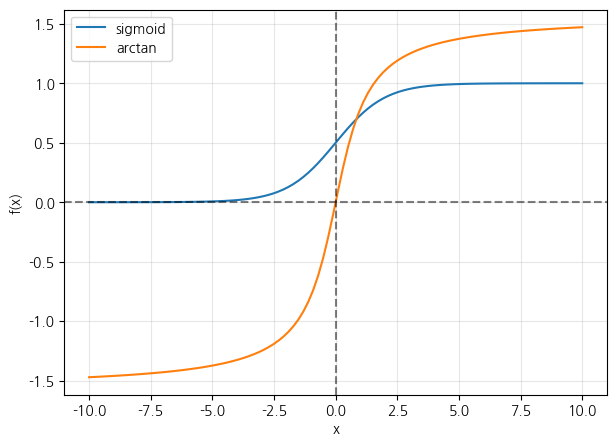

In [5]:
# Sigmoid & Arctangent : 73p
def sigmoid(x):
    x = np.array(x, dtype=np.float64)
    return 1 / (1 + np.exp(-x))

x = np.linspace(-10,10,num=100)
y1 = sigmoid(x)
y2 = np.arctan(x)

plt.figure(figsize=(7,5))
plt.plot(x,y1,'-')
plt.plot(x,y2,'-')
plt.grid(alpha=0.3)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['sigmoid','arctan'])
plt.show()

In [6]:
# Softmax : 94p
def softmax(x):
    x = np.array(x, dtype=np.float64)

    z = x - np.max(x, axis=-1, keepdims=True) # overflow 방지
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    softmax = numerator / denominator
    
    return softmax

x = [[199,200,200], [1,2,3]]
print(softmax(x).round(4))
print(softmax(x).sum(axis=1))

[[0.1554 0.4223 0.4223]
 [0.09   0.2447 0.6652]]
[1. 1.]


In [7]:
# Cross entropy : 115p

# y_true와 y_pred의 모든 요소를 고려하여 계산하는 방법
def cross_entropy_error(y_true, y_pred):
    delta = 1e-7

    y_true = np.array(y_true, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)
    
    cee = -np.sum(y_true * np.log(y_pred+delta))
    return cee

# y_true가 원-핫 인코딩일 경우, 정답에 해당하는 클래스의 예측 확률에만 집중해서 계산하는 방법
# (1) 계산 효율성: 정답이 아닌 클래스에 대해서도 불필요한 곱셈과 로그 계산을 줄임
# (2) 정확성: 정답 클래스에 해당하는 예측 확률만을 사용해 손실을 계산하므로, 실제로 필요한 정보를 정확하게 추출
def cross_entropy_error(y_true, y_pred):
    delta = 1e-7

    y_true = np.array(y_true, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)

    if y_pred.ndim == 1:
        y_true = y_true.reshape(1, y_true.size)
        y_pred = y_pred.reshape(1, y_pred.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if y_true.size == y_pred.size:
        y_true = y_true.argmax(axis=1)
    else:
        y_true = y_true.astype('uint')

    # 정답 클래스에 해당하는 예측 확률만을 사용해 batch size 내 평균손실을 계산
    batch_size = y_pred.shape[0]
    cee = -np.mean(np.log(y_pred[np.arange(batch_size), y_true] + delta))

    return cee

In [8]:
y_true = [0,0,1,0,0,0,0,0,0,0]
y_pred = [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
cross_entropy_error(y_true, y_pred)

0.510825457099338

In [9]:
# 수치미분값 : 123p
def numerical_diff(f,x):
    x = np.array(x, dtype=np.float64)
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

# 접선기울기값 : 125p
def tangent_line(f, x):
    x = np.array(x, dtype=np.float64)
    d = numerical_diff(f, x) # f'(x) : 기울기
    # 접선의 방정식을 f'(x0) = d*x0 + y0로 표현하면, x0값이 주어질 때 이에 해당하는 y축절편의 값인 y0를 모름
    # 이 값을 유도하기위해, 기존 함수인 f(x0)=f'(x0)를 사용한다. (x0에서의 접선이므로, f(x0)값과 f'(x0)값은 같으므로)
    # 즉, y0 = f'(x0) - d*x0 = f(x0) - d*x0가 된다.
    y = f(x) - d*x

    # f'(x) = 기울기 * x값 + y절편값
    return lambda t: d*t + y

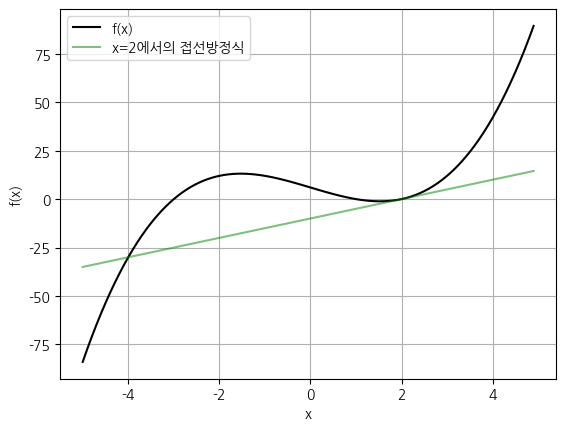

In [10]:
def f(x):
    #return x**2
    return (x-2)*(x-1)*(x+3)

x = np.arange(-5.0, 5.0, 0.1)

x0 = 2
tf = tangent_line(f, x0)
y1 = f(x)
y2 = tf(x)

plt.figure()
plt.plot(x, y1, color='black')
plt.plot(x, y2, color='green', alpha=0.5)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.legend(['f(x)',f'x={x0}에서의 접선방정식'])
plt.show()

In [11]:
# partial derivative : 127p
def _numerical_gradient_no_batch(f, x):
    x = np.array(x, dtype=np.float64)

    h = 1e-4
    grad = np.zeros_like(x, dtype=np.float64)

    for idx in np.ndindex(x.shape):
        # 해당 idx에만 h를 더해주거나 빼주도록 h vector를 생성
        h_vector = np.zeros_like(x)
        h_vector[idx] = h

        grad[idx] = (f(x+h_vector) - f(x-h_vector)) / (2*h)

    return grad

def numerical_gradient(f, X):
    X = np.array(X, dtype=np.float64)
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        return grad

def f(x):
    x = np.array(x, dtype=np.float64)
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

In [12]:
for x in [[3,4],[0,2],[3,0]]:
    x = np.array(x)
    print(numerical_gradient(f, x))

[6. 8.]
[0. 4.]
[6. 0.]


In [13]:
# 다른 방식의 수치적 기울기 계산 함수
def numerical_gradient_2(f, x):
    # 이 부분이 추가되지 않으면 grad 결과값의 오차가 커짐
    x = np.array(x, dtype=np.float64)

    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        
        x[idx] = tmp_val + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 원래 값 복원
        it.iternext()
        
    return grad

In [14]:
for x in [[3,4],[0,2],[3,0]]:
    x = np.array(x)
    print(numerical_gradient_2(f, x))

[6. 8.]
[0. 4.]
[6. 0.]


In [15]:
# gradient plot : 129p
def gradient_plot(f, minval, maxval):
    x1 = x2 = np.linspace(minval, maxval, num=20)
    X1, X2 = np.meshgrid(x1, x2)
    Y = f([X1,X2])

    # calculate the gradient
    grad = numerical_gradient(f, [X1.flatten(), X2.flatten()])

    # visualization
    fig = plt.figure(figsize=(15,7))

    # (1) 2d gradient vector field
    ax1 = fig.add_subplot(121)
    ax1.quiver(X1, X2, -grad[0], -grad[1], angles="xy", color="#666666")#,headwidth=10,scale=40,color="#444444")
    ax1.set_xlim([minval, maxval])
    ax1.set_ylim([minval, maxval])
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.grid()
    ax1.set_title('2D Gradient Vector Field')

    # (2) 3d plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X1, X2, Y, cmap='viridis')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('y')
    ax2.grid()
    ax2.set_title('3D Plot')
    
    plt.tight_layout()
    plt.show()

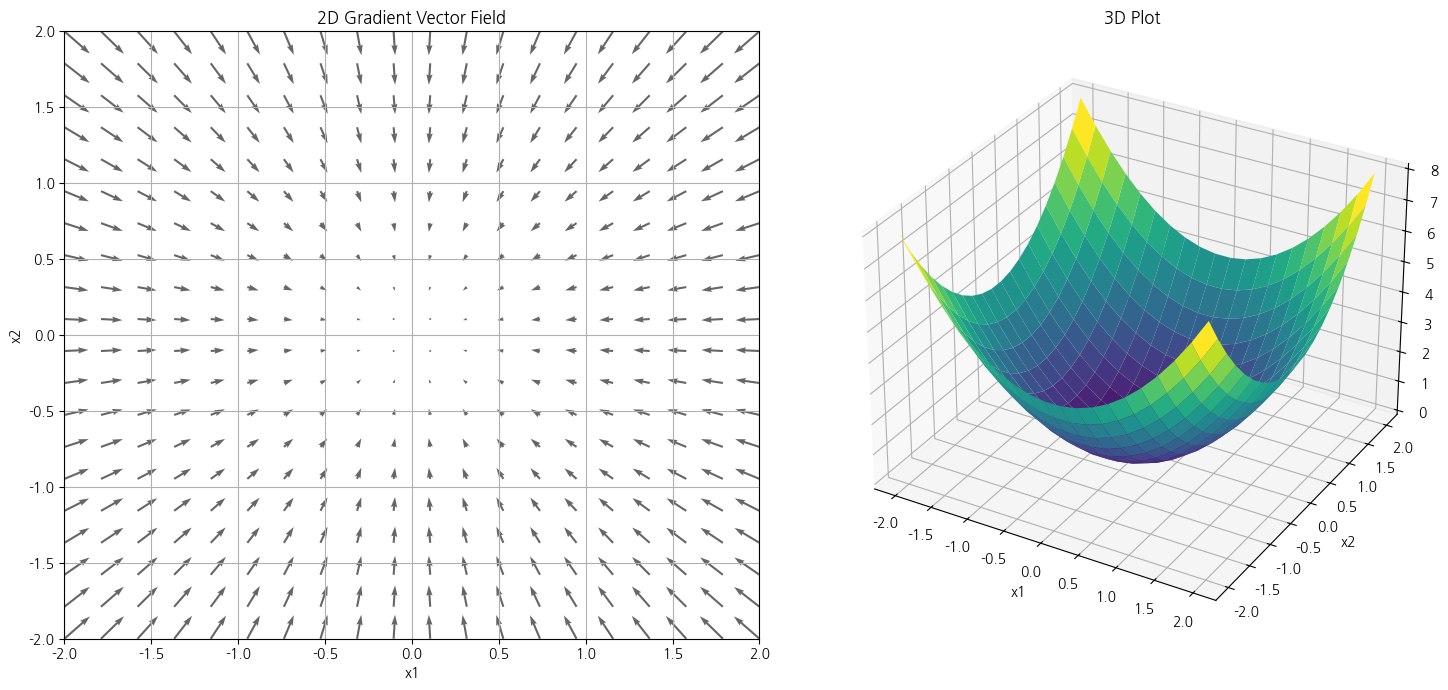

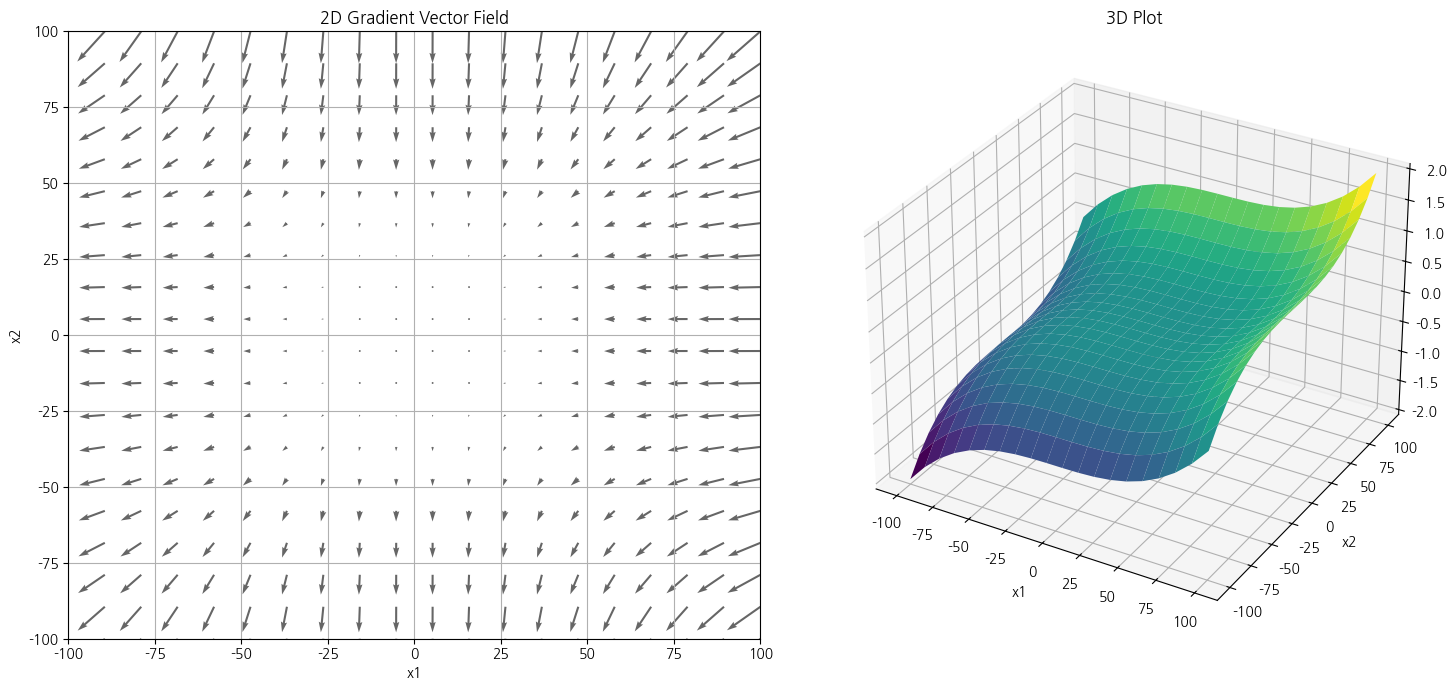

In [16]:
gradient_plot(lambda t: sum(np.array(t)**2), -2, 2)
gradient_plot(lambda t: sum(np.array(t)**3), -100, 100)

In [17]:
# gradient descent : 131p
def gradient_descent(f, init, lr=0.01, step_num=100):
    x = np.array(init, dtype=np.float64)
    x_history = []

    for i in range(step_num):
        x_history.append(x.copy())

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

# gradient descent plot : 132p
def gradient_descent_plot(f, init, lr, step_num, minval, maxval):
    x, x_history = gradient_descent(f, init, lr=lr, step_num=step_num)

    offset = 1.2
    x1 = x2 = np.linspace(minval*offset, maxval*offset, num=20)
    X1, X2 = np.meshgrid(x1, x2)
    # [X1,X2]로 하게되면 2개의 batch로 인식 할 수 있으므로 [[X1,X2]]로 묶어주고, squeeze를 통해 차원이 1인 축을 제거
    Y = f([[X1,X2]]).squeeze()

    # visualization
    plt.figure(figsize=(7,7))

    # (1) contour
    plt.contour(X1, X2, Y, levels=max(abs(minval),abs(maxval)), colors='gray', linestyles='dashed')

    # (2) gradient descent moving
    for i in range(len(x_history)-1):
        val_dict = {
            'X' : x_history[i, 0],
            'Y' : x_history[i, 1],
            'U' : x_history[i+1, 0] - x_history[i, 0],
            'V' : x_history[i+1, 1] - x_history[i, 1],
        }
        plt.quiver(*list(val_dict.values()), angles='xy', scale_units='xy', scale=1.1, color='blue', width=0.003, alpha=0.5)
        plt.annotate(str(i+1), [val_dict['X']-0.3, val_dict['Y']], color='blue', alpha=0.5)

    # base line
    plt.axvline(0, color='black', linestyle='-', alpha=0.8)
    plt.axhline(0, color='black', linestyle='-', alpha=0.8)
    plt.plot(x_history[:,0], x_history[:,1], 'ob', markersize=3)

    plt.xlim(minval, maxval)
    plt.ylim(minval, maxval)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

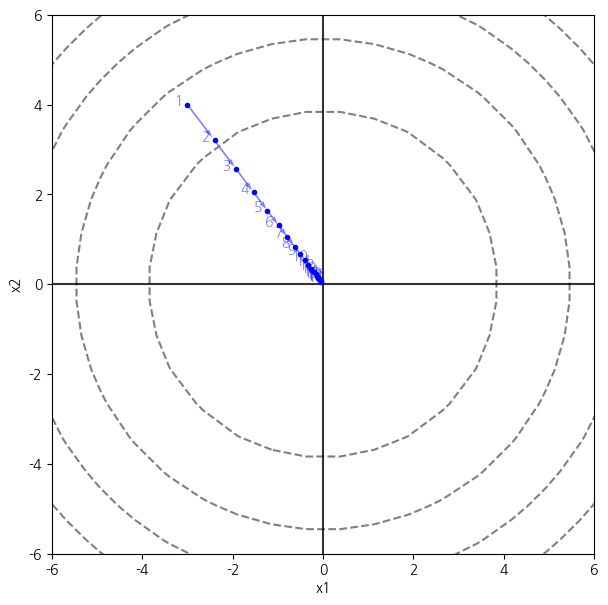

In [18]:
gradient_descent_plot(f, init=[-3,4], lr=0.1, step_num=20, minval=-6, maxval=6)

In [19]:
# simple network : 134p
# -> loss() 함수에 w를 넣지 않으면 lambda w: net.loss(x,t)에서 w 매개변수가 없어 기울기를 계산할 수 없음
class SimpleNet:
    def __init__(self, input_size, output_size):
        self.input_size = input_size    # 입력된 데이터의 개수
        self.output_size = output_size  # true label의 nunique

        np.random.seed(42)
        self.weight = np.random.randn(input_size, output_size)
        self.bias = np.zeros(output_size)

    def predict(self, x, weight=None, bias=None):
        if weight is None:
            weight = self.weight
        if bias is None:
            bias = self.bias
        z = x @ weight + bias
        return z

    def loss(self, x, y_true, weight=None, bias=None):
        if weight is None:
            weight = self.weight
        if bias is None:
            bias = self.bias
        z = self.predict(x, weight, bias)
        y_pred = softmax(z)
        loss = cross_entropy_error(y_true=y_true, y_pred=y_pred)
        return loss

In [20]:
x = [0.6,0.9]
t = [1,0,0] # true label: 0,1,2 중 2이라는 뜻의 one-hot encoding

# x = [0.5, 0.4, 0.8]
# t = [0,1]

net = SimpleNet(input_size=len(x), output_size=len(t))
print('> Weights:') # weight matrix
print(net.weight,'\n')

z = net.predict(x) # z
print(f'> z: {z} \n')

y_pred = softmax(z)
print(f'> Predicted Probability: {y_pred} \n')

prediction = np.argmax(z) # prediction label
print(f'> Predicted Label: {prediction} \n')

loss = net.loss(x, t)
print(f'> Cross Entropy Loss: {loss:.5f}')

> Weights:
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]] 

> z: [ 1.66875536 -0.29369662  0.17788986] 

> Predicted Probability: [0.73222998 0.10288817 0.16488185] 

> Predicted Label: 0 

> Cross Entropy Loss: 0.31166


In [21]:
# dw (weight의 기울기)

# (1) 수치적 기울기 계산
# -> loss() 함수에 w를 넣지 않으면 lambda w: net.loss(x,t)에서 w 매개변수가 없어 기울기를 계산할 수 없음
# -> 따라서, w를 매개변수로 넣어줘야함
f = lambda w: net.loss(x, t, w, None)
dW1 = numerical_gradient(f, net.weight[np.newaxis, :, :])
print(dW1)

[[[-0.16066199  0.06173289  0.0989291 ]
  [-0.24099298  0.09259934  0.14839364]]]


In [22]:
# (2) 해석적 기울기 계산
# 참조 : https://davidbieber.com/snippets/2020-12-12-derivative-of-softmax-and-the-softmax-cross-entropy-loss/
def analytical_gradient(x, y_true, y_pred):
    return np.outer(x, (y_pred - y_true))

# 해석적 기울기 계산
dW2 = analytical_gradient(x, t, y_pred)
print(dW2)

[[-0.16066201  0.0617329   0.09892911]
 [-0.24099302  0.09259935  0.14839366]]


In [23]:
(dW1-dW2).round(7)

array([[[ 0., -0., -0.],
        [ 0., -0., -0.]]])

In [24]:
# 2층 신경망 구현 : 137p
from tqdm import tqdm, trange
from collections import OrderedDict
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

def identity(x):
    return x

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x>0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class MultiLayerNet:
    def __init__(self, input_size, output_size, hidden_sizes, activation=None):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes

        self.node_sizes = [input_size] + hidden_sizes + [output_size]
        self.n_layers = len(self.node_sizes)-1

        if activation in ['sigmoid',None]:
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation=='relu':
            self.activation = relu
            self.activation_derivative = relu_derivative

        if activation is None:
            self.weight_init()
        elif activation=='sigmoid':
            self.weight_init(method='Xavier')
        elif activation=='relu':
            self.weight_init(method='He')

    # def weight_init(self, weight_init_std=0.01, seed=42):
    #     np.random.seed(seed)
    #     self.params = {'weights': OrderedDict(), 'biases': OrderedDict()}

    #     for i in range(self.n_layers):
    #         self.params['weights'][f'w{i}'] = weight_init_std * np.random.randn(self.node_sizes[i], self.node_sizes[i+1])
    #         self.params['biases'] [f'b{i}'] = np.zeros(self.node_sizes[i+1])

    # Xavier, He, Default(torch에서 사용하는 방식)
    # > 책 205p
    # > torch 공식문서
    #   - nn.Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    #   - nn.Conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    def weight_init(self, method=None, seed=42):
        np.random.seed(seed)
        self.params = {'weights': OrderedDict(), 'biases': OrderedDict()}

        for i in range(self.n_layers):
            input_dim = self.node_sizes[i]
            output_dim = self.node_sizes[i+1]

            if method is None:
                limit = 0.01
            elif method == 'Xavier':
                limit = np.sqrt(1 / input_dim)   # Xavier initialization
            elif method == 'He':
                limit = np.sqrt(2 / input_dim)   # He initialization
            else:
                raise ValueError

            self.params['weights'][f'w{i}'] = np.random.randn(input_dim, output_dim) * limit
            self.params['biases'] [f'b{i}'] = np.random.randn(output_dim) * limit

    def predict(self, x, params=None, return_activations=False):
        if params is None:
            weights = deepcopy(self.params['weights'])
            biases = deepcopy(self.params['biases'])
        else:
            weights = params['weights']
            biases = params['biases']

        if return_activations:
            activations = []

        # 초기 activation은 x로 초기화
        activation = x
        
        # layer들의 선형결합
        for j, ((w_name, w_ij), (b_name, b_j)) in enumerate(zip(weights.items(), biases.items())):
            # logit (linear combination)
            logits = activation @ w_ij + b_j

            # activation function
            if j+1 != self.n_layers:
                activation = self.activation(logits)
            else:
                activation = logits
            
            if return_activations:
                activations.append(activation)

        if return_activations:
            return activation, activations
        else:
            return activation

    def loss(self, x, y_true, params=None):
        activation = self.predict(x, params)
        prob = softmax(activation)
        loss = cross_entropy_error(y_true=y_true, y_pred=prob)
        return loss

    def accuracy(self, x, y_true):
        y_pred = self.predict(x)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_true, axis=1)
        
        acc = np.sum(y_pred==y_true) / len(y_pred)
        return acc

    def _compute_numerical_gradient(self, x, y_true, name, idx, what):
        h = 1e-4

        # set params
        params = {'weights': deepcopy(self.params['weights']), 'biases': deepcopy(self.params['biases'])}
        val = params[what][name][idx]

        # f(x+h)
        params[what][name][idx] = val + h
        fxh1 = self.loss(x, y_true, params)
        # f(x-h)
        params[what][name][idx] = val - h
        fxh2 = self.loss(x, y_true, params)

        # ( f(x+h) - f(x-h) ) / 2h
        return (fxh1 - fxh2) / (2*h)

    def numerical_gradient(self, x, y_true, max_workers=1):
        Executor = ThreadPoolExecutor # ThreadPoolExecutor. ProcessPoolExecutor
        params = {'weights': OrderedDict(), 'biases': OrderedDict()}
        weights = self.params['weights']
        biases = self.params['biases']

        for j, ((w_name, w_ij), (b_name, b_j)) in enumerate(zip(weights.items(), biases.items())):
            
            # (1) weight gradients
            iterable = np.ndindex(weights[w_name].shape)
            total = weights[w_name].size
            desc = f'[{j+1}/{len(weights)}] - weights'

            grad_weight = np.zeros_like(weights[w_name], dtype=np.float64)

            if max_workers==1:
                pbar = tqdm(iterable, total=total, desc=desc)
                for idx in pbar:
                    grad_weight[idx] = self._compute_numerical_gradient(x, y_true, w_name, idx, 'weights')
            else:
                with Executor(max_workers=max_workers) as executor:
                    futures = {
                        executor.submit(self._compute_numerical_gradient, x, y_true, w_name, idx, 'weights'): idx
                        for idx in iterable
                    }
                    #pbar = tqdm(as_completed(futures), total=total, desc=desc, position=0, leave=False)
                    pbar = as_completed(futures)
                    for future in pbar:
                        idx = futures[future]
                        grad_weight[idx] = future.result()

            params['weights'][w_name] = grad_weight

            # (2) bias gradients
            grad_bias = np.zeros_like(biases[b_name], dtype=np.float64)

            iterable = np.ndindex(biases[b_name].shape)
            total = biases[b_name].size
            desc = f'[{j+1}/{len(biases)}] - biases'

            if max_workers==1:
                pbar = tqdm(iterable, total=total, desc=desc)
                for idx in pbar:
                    grad_bias[idx] = self._compute_numerical_gradient(x, y_true, b_name, idx, 'biases')
            else:
                with Executor(max_workers=max_workers) as executor:
                    futures = {
                        executor.submit(self._compute_numerical_gradient, x, y_true, b_name, idx, 'biases'): idx
                        for idx in pbar
                    }
                    #pbar = tqdm(as_completed(futures), total=total, desc=desc, position=0, leave=False)
                    pbar = as_completed(futures)
                    for future in pbar:
                        idx = futures[future]
                        grad_bias[idx] = future.result()

            params['biases'][b_name] = grad_bias

        return params

In [25]:
n = 5
input_size = 50
output_size = 3
hidden_sizes = [16]

net = MultiLayerNet(input_size, output_size, hidden_sizes, activation=None)
print(f"> node sizes: {net.node_sizes}")
print(f"> weights sizes: {[v.shape for k,v in net.params['weights'].items()]}")
print(f"> bias sizes: {[v.shape for k,v in net.params['biases'].items()]}")

x = np.random.rand(n, input_size)
y_true = np.random.rand(n, output_size)

y_pred = net.predict(x)
print(f"> y_pred size: {y_pred.shape}")

loss = net.loss(x, y_true)
print(f"> loss: {loss:.4f}")

acc = net.accuracy(x, y_true)
print(f"> accuracy: {acc:.4f}")

> node sizes: [50, 16, 3]
> weights sizes: [(50, 16), (16, 3)]
> bias sizes: [(16,), (3,)]
> y_pred size: (5, 3)
> loss: 1.0911
> accuracy: 0.4000


In [26]:
# relu인 경우 출력값이 음수인 경우 0이 되므로 가중치가 0이 될 수 있음
numerical_grads = net.numerical_gradient(x, y_true, max_workers=8)
numerical_grads['weights']['w0']

array([[ 7.11086046e-05, -1.18349249e-04,  1.41766869e-03,
         9.58270800e-04,  4.46044617e-04, -7.08775949e-05,
        -7.80116673e-04, -4.42368548e-04,  5.00803274e-04,
        -4.70062567e-05,  3.85842329e-04,  1.47160206e-05,
        -1.05789115e-03, -4.98378748e-04, -4.03812794e-04,
        -1.70494394e-03],
       [ 9.85463766e-05, -2.00013530e-04,  9.77512545e-04,
         7.86862667e-04,  3.71442300e-04, -6.31783281e-05,
        -6.16022217e-04, -2.29553123e-04,  4.54343783e-04,
        -5.23352905e-05,  4.54986185e-04,  5.92110250e-06,
        -7.39927467e-04, -4.22299381e-04, -2.50477715e-04,
        -1.18498705e-03],
       [ 1.49672191e-04, -3.29905763e-04,  7.67751990e-04,
         8.02205806e-04,  3.85034968e-04, -7.05157011e-05,
        -5.98134070e-04, -7.01020231e-05,  5.16007552e-04,
        -7.01813274e-05,  6.33498088e-04, -1.51199053e-06,
        -5.96418360e-04, -4.46214217e-04, -1.55882627e-04,
        -9.43985281e-04],
       [-1.33867241e-04,  3.60752919e

In [27]:
# 미니배치 구현 : 141p

def label_onehot(label, num_classes):
    label = np.array(label)
    label = label - min(label)
    onehot = np.zeros((len(label), num_classes))
    for i, l in enumerate(label):
        onehot[i, l] = 1
    return onehot

# # HTTP 403 에러 뜸
# from dataset.mnist import load_mnist
# (X_train, y_train), (X_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

# normalize
X_train, X_test = X_train / 255.0, X_test / 255.0

# X -> flatten
X_train = X_train.reshape(X_train.shape[0], -1)
X_test  = X_test .reshape(X_test .shape[0], -1)

In [28]:
# max_workers = os.cpu_count() // 2
# iters_num = 100
# train_size = X_train.shape[0]
# batch_size = 100
# lr = 0.1

# input_size = 784
# output_size = 10
# hidden_sizes = [50]

# model = MultiLayerNet(input_size, output_size, hidden_sizes, activation=None)

# elapsed_times = []
# train_loss_list = []
# val_loss_list = []
# for i in range(iters_num):
#     start_time = time.time()

#     # get mini-batch (실제로는 모든 6만개의 데이터에 대해서 모두 가중치 업데이트를 해야 1개의 epoch로 쳐줌)
#     batch_mask = np.random.choice(train_size, batch_size)
#     X_batch, y_batch = X_train[batch_mask], y_train[batch_mask]
    
#     # calculate gradients
#     grads = model.numerical_gradient(X_batch, y_batch, max_workers=max_workers)

#     # gradient descent
#     for grad_key in grads.keys():
#         for key in grads[grad_key]:
#             model.params[grad_key][key] -= lr * grads[grad_key][key]

#     # loss
#     train_loss = model.loss(X_batch, y_batch)
#     val_loss   = model.loss(X_test, y_test)

#     train_loss_list.append(train_loss)
#     val_loss_list  .append(val_loss)

#     # progress
#     now_time = str(datetime.datetime.now())[:-7]
#     end_time = time.time()
#     elapsed = end_time-start_time
#     elapsed_times.append(elapsed)
#     total = sum(elapsed_times)
#     remaining = (iters_num-i-1) * elapsed

#     str_i = str(i+1).zfill(len(str(iters_num)))
#     progress = f'{now_time} | [{str_i}/{iters_num}] {train_loss=:.4f}, {val_loss=:.4f}, {elapsed=:.1f}s, {total=:.1f}s, {remaining=:.1f}s'
#     print(progress)

In [29]:
# 곱셈 계층 : 161p
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y # 순전파는 곱셈으로 반환

    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꾸어서 미분값에 곱함
        dy = dout * self.x
        return dx, dy

# 덧셈 계층 : 163p
class AddLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x + y # 순전파는 덧셈으로 반환

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy # 값 그대로(1을 곱한채로) 반환

In [30]:
# 곱셈 계층 예제 : 162p
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# (1) forward : input 2, output 1
apple = 100
apple_num = 2
tax = 1.1

apple_price = mul_apple_layer.forward(apple, apple_num) # (1-1) 사과가격(100) * 사과개수(2)
price = mul_tax_layer.forward(apple_price, tax)         # (1-2) 전체사과가격(200) * 세금(1.1)
print(price)

# (2) backward : input 1, output 2
dprice = 1

dapple_price, dtax = mul_tax_layer.backward(dprice)         # (2-2) 전체가격 -> 세금
dapple, dapple_num = mul_apple_layer.backward(dapple_price) # (2-1) 세금 -> 사과가격,개수
print(dapple, dapple_num, dtax)

220.00000000000003
2.2 110.00000000000001 200


In [31]:
# 곱셈+덧셈 계층 예제 : 164p

# (1) forward

# (1-1) 사과와 오렌지의 각각의 가격 및 개수
apple_price, apple_num = 100, 2   # 100원짜리 사과 2개
orange_price, orange_num = 150, 3 # 150원짜리 오렌지 3개

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()

tot_apple_price = mul_apple_layer.forward(apple_price, apple_num)
tot_orange_price = mul_orange_layer.forward(orange_price, orange_num)

# (1-2) 사과와 오렌지의 전체 가격 합치기
add_apple_orange_layer = AddLayer()

tot_price = add_apple_orange_layer.forward(tot_apple_price, tot_orange_price)

# (1-3) 소비세 곱하기
tax_ratio = 1.1

mul_tax_layer = MulLayer()

final_price = mul_tax_layer.forward(tot_price, tax_ratio)

# forward result
print(f'\n> forward',
      f'\n   step1: {tot_apple_price=:.2f}, {tot_orange_price=:.2f},',
      f'\n   step2: {tot_price=:.2f},',
      f'\n   step3: {final_price=:.2f}')

# (2) backward
# - forward와는 순서가 반대로
# - forward에 input이었던 것들이 output으로, output이었던 것이 input으로

# (2-1) 전체 가격과 세금 나누기
dfinal_price = 1

dtot_price, dtax_ratio = mul_tax_layer.backward(dfinal_price)

# (2-2) 사과와 오렌지의 전체 가격 나누기
dtot_apple_price, dtot_orange_price = add_apple_orange_layer.backward(dtot_price)

# (2-3) 사과와 오렌지의 가격 및 개수 나누기
dapple_price, dapple_num = mul_apple_layer.backward(dtot_apple_price)
dorange_price, dorange_num = mul_orange_layer.backward(dtot_orange_price)

# backward result
print(f'\n> backward',
      f'\n   step1: {dtot_price=:.2f}, {dtax_ratio=:.2f},',
      f'\n   step2: {dtot_apple_price=:.2f}, {dtot_orange_price=:.2f},',
      f'\n   step3: {dapple_price=:.2f}, {dapple_num=:.2f}, {dorange_price=:.2f}, {dorange_num=:.2f}')


> forward 
   step1: tot_apple_price=200.00, tot_orange_price=450.00, 
   step2: tot_price=650.00, 
   step3: final_price=715.00

> backward 
   step1: dtot_price=1.10, dtax_ratio=650.00, 
   step2: dtot_apple_price=1.10, dtot_orange_price=1.10, 
   step3: dapple_price=2.20, dapple_num=110.00, dorange_price=3.30, dorange_num=165.00


In [32]:
# relu 계층 구현 : 166p
class ReLU:
    def __init__(self):
        self.negative_mask = None

    def forward(self, x):
        self.negative_mask = (x <= 0)
        out = np.where(self.negative_mask, 0, x) # 0보다 큰 값은 값그대로, 0보다 작은 값은 0으로
        return out

    def backward(self, dout):
        dx = np.where(self.negative_mask, 0, dout) # 0보다 큰 값은 값그대로, 0보다 작은 값은 0으로 (dout 값에 relu_derivative를 곱해줌)
        return dx

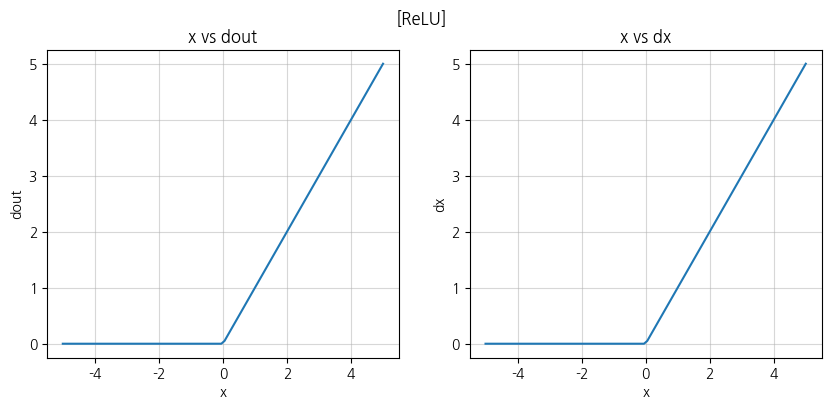

In [33]:
x = np.linspace(-5,5,num=100)
activation = ReLU()
dout = activation.forward(x)
dx = activation.backward(dout)

fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(x, dout)
plt.grid(alpha=0.5)
plt.xlabel('x')
plt.ylabel('dout')
plt.title('x vs dout')
fig.add_subplot(1,2,2)
plt.plot(x, dx)
plt.grid(alpha=0.5)
plt.xlabel('x')
plt.ylabel('dx')
plt.title('x vs dx')
plt.suptitle(f'[{activation.__class__.__name__}]')
plt.show()

In [34]:
class LeakyReLU:
    def __init__(self, negative_slope=0.01):
        self.negative_slope = negative_slope
        self.negative_mask = None

    def forward(self, x):
        self.negative_mask = (x <= 0)
        out = np.where(self.negative_mask, self.negative_slope*x, x) # 0보다 큰 값은 값그대로, 0보다 작은 값은 negative slope를 곱한 값으로
        return out

    def backward(self, dout):
        dx = np.where(self.negative_mask, self.negative_slope*dout, dout) # 0보다 큰 값은 값그대로, 0보다 작은 값은 negative slope를 곱한 값으로 (dout 값에 leakyrelu_derivative를 곱해줌)
        return dx

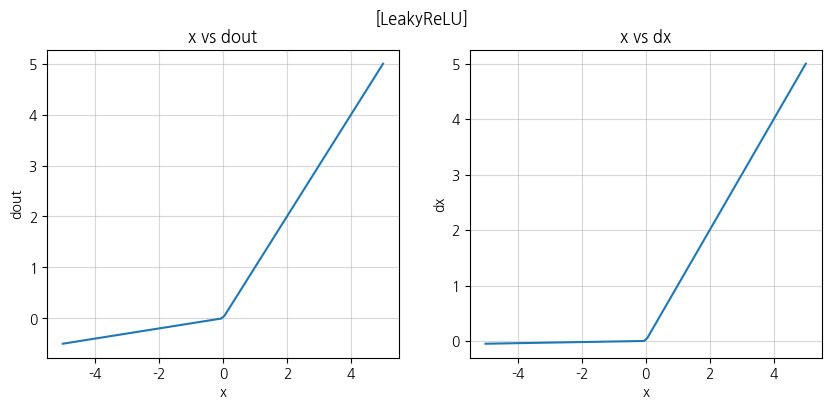

In [35]:
x = np.linspace(-5,5,num=100)
activation = LeakyReLU(negative_slope=0.1)
dout = activation.forward(x)
dx = activation.backward(dout)

fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(x, dout)
plt.grid(alpha=0.5)
plt.xlabel('x')
plt.ylabel('dout')
plt.title('x vs dout')
fig.add_subplot(1,2,2)
plt.plot(x, dx)
plt.grid(alpha=0.5)
plt.xlabel('x')
plt.ylabel('dx')
plt.title('x vs dx')
plt.suptitle(f'[{activation.__class__.__name__}]')
plt.show()

In [36]:
# sigmoid 계층 구현 : 170p
class Sigmoid:
    def __init__(self):
        pass

    def forward(self, x):
        self.out = np.where(x>0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(-x))) # overflow 방지
        return self.out

    def backward(self, dout):
        dx = dout * self.out * (1.0-self.out)
        return dx

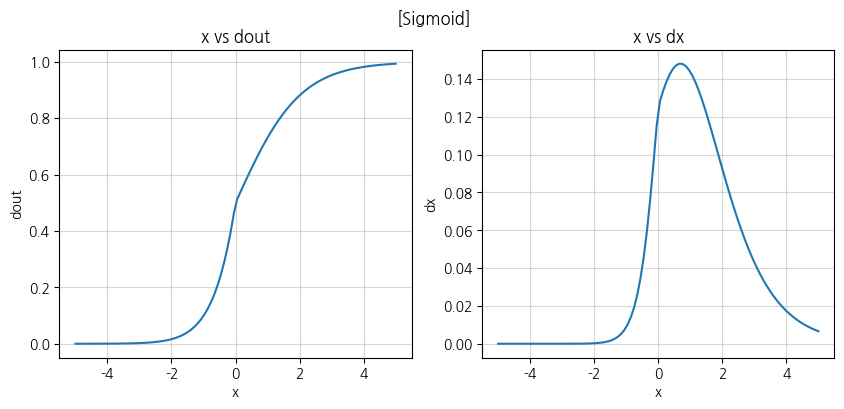

In [37]:
x = np.linspace(-5,5,num=100)
activation = Sigmoid()
dout = activation.forward(x)
dx = activation.backward(dout)

fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(x, dout)
plt.grid(alpha=0.5)
plt.xlabel('x')
plt.ylabel('dout')
plt.title('x vs dout')
fig.add_subplot(1,2,2)
plt.plot(x, dx)
plt.grid(alpha=0.5)
plt.xlabel('x')
plt.ylabel('dx')
plt.title('x vs dx')
plt.suptitle(f'[{activation.__class__.__name__}]')
plt.show()

In [38]:
# Affine 계층 구현 : 175p
class Affine:
    def __init__(self, in_features, out_features, weight_init_method=None, weight_init_limit=None):
        self.in_features = in_features
        self.out_features = out_features
        self.weight_init_method = str(weight_init_method).lower()
        self.weight = None
        self.bias = None

        if (weight_init_method is None) and (weight_init_limit is None):
            self.weight_init_limit = 0.01
        else:
            self.weight_init_limit = weight_init_limit

        # 가중치와 편향의 gradient descent를 위해 각각의 기울기를 저장
        self.dW = None
        self.db = None

        self.__weight_init(method=self.weight_init_method)

    # > 책 205p
    # > torch 공식문서
    #   - nn.Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    #   - nn.Conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    def __weight_init(self, method=None, seed=42):
        np.random.seed(seed)

        if method == 'none':
            limit = self.weight_init_limit
        elif method == 'xavier':
            limit = np.sqrt(1 / self.in_features)   # Xavier initialization
        elif method == 'he':
            limit = np.sqrt(2 / self.in_features)   # He initialization
        else:
            raise ValueError

        self.weight = np.random.randn(self.in_features, self.out_features) * limit
        self.bias = np.random.randn(self.out_features) * limit

    def forward(self, X):
        self.X = X
        self.origin_shape = self.X.shape

        # 다차원인 경우, batch에 대해서 적용하기위해 평탄화(2D로 변환) 시켜줌
        if self.X.ndim > 2:
            self.X = self.X.reshape(self.X.shape[0], -1)
        
        out = self.X @ self.weight + self.bias # out = XW + b
        
        return out

    def backward(self, dout):
        dout = np.array(dout)
        self.dW = self.X.T @ dout        # dL/dW = X^T * dL/dY
        self.db = np.sum(dout, axis=0)   # dL/dB = dL/dY = sum(dL_j/dY)
        dX = dout @ self.weight.T        # dL/dX = dL/dY * W^T
        dX = dX.reshape(self.origin_shape)
        return dX

    def update(self, weight, bias):
        self.weight = weight
        self.bias = bias

In [39]:
batch_size = 20
input_dim = 3
output_dim = 4

X = np.random.randn(batch_size,input_dim)                     # X : (batch_size, input_size)

affine = Affine(input_dim, output_dim)
print('weight, bias:',affine.weight.shape, affine.bias.shape) # weight : (input_size, output_size), bias : (output_size, )
out = affine.forward(X)
print('forward:',out.shape)                                   # forward : (batch_size, output_size) = (batch_size, input_size) @ (input_size, output_sizse)
dout = np.ones((batch_size,output_dim))
dout = affine.backward(dout)
print('dout:',dout.shape)                                     # backward : (batch_size, input_size)
print('dW, db:',affine.dW.shape, affine.db.shape)             # shape of dW, db = shape of W, b

weight, bias: (3, 4) (4,)
forward: (20, 4)
dout: (20, 3)
dW, db: (3, 4) (4,)


In [40]:
# 참조 : https://slamwithme.oopy.io/305bb7e0-1062-4785-a82e-9e2a5debd0f4

# (1) Binary Class
#   (1-1) torch.nn.BCELoss() : Layer(affine, activation, batchnorm 등의 조합) 마지막에 sigmoid 추가 필요
#   (1-2) torch.nn.BCEWithLogitsLoss() : Layer 마지막에 sigmoid 추가 불필요 (sigmoid가 포함되어있음)
#

# (2) Multiple Class
#   : torch.nn.CrossEntropyLoss() : Layer 마지막에 softmax 추가 불필요 (softmax가 포함되어있음)

In [41]:
# Softmax with loss 계층 구현 : 179p
# -> torch.nn.CrossEntropyLoss() 구현 예제
class SoftmaxWithLoss:
    def __init__(self):
        self.y = None
        self.t = None

    def forward(self, y, t):
        self.y = softmax(np.array(y))
        self.t = np.array(t)

        # cross entropy loss
        self.loss = cross_entropy_error(y_pred=self.y, y_true=self.t)

        return self.loss

    def backward(self): # dout의 영향을 받지 않음
        # true값이 onehot인 경우
        batch_size = self.t.shape[0]
        if self.y.size == self.t.size:
            dx = (self.y - self.t)
        # true값이 정수형인 경우
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1  # 예측 확률에서 실제 정수형 레이블에 해당하는 값을 1 뺌

        # 오차를 batch size로 나눠서 역전파
        dx /= batch_size

        return dx

In [42]:
# 역전파를 이용한 MultiLayerNet 구현 : 182p
from tqdm import tqdm, trange
from collections import OrderedDict
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

class MultiLayerNet:
    def __init__(self, input_size, output_size, hidden_sizes, activation=None, weight_init_method='auto', weight_init_limit=None):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.weight_init_limit = weight_init_limit

        self.node_sizes = [input_size] + hidden_sizes + [output_size]
        self.n_layers = len(self.node_sizes)-1

        # activation
        if activation is None:
            activation = 'sigmoid'
        else:
            activation = activation.lower()

        activation_dict = {
            'sigmoid' : Sigmoid(),
            'relu' : ReLU(),
        }
        self.activation = activation_dict.get(activation)

        # weight init
        if weight_init_method=='auto':
            if activation=='sigmoid':
                weight_init_method = 'Xavier'
            elif activation in ['relu','leakyrelu']:
                weight_init_method = 'He'

        # define layers
        self.params = {'weights': OrderedDict(), 'biases': OrderedDict()}
        self.layers_backward = OrderedDict()
        for i in range(self.n_layers):
            input_dim = self.node_sizes[i]
            output_dim = self.node_sizes[i+1]
            self.layers_backward[f'Affine{i+1}'] = Affine(input_dim, output_dim, weight_init_method, weight_init_limit)
            self.params['weights'][f'w{i+1}'] = self.layers_backward[f'Affine{i+1}'].weight
            self.params['biases'] [f'b{i+1}'] = self.layers_backward[f'Affine{i+1}'].bias
            if i+1 != self.n_layers:
                self.layers_backward[f'Activation{i+1}'] = deepcopy(self.activation)
        self.last_layer = SoftmaxWithLoss()

    def predict_numerical_gradient(self, x, params=None, return_activations=False):
        if params is None:
            weights = deepcopy(self.params['weights'])
            biases = deepcopy(self.params['biases'])
        else:
            weights = params['weights']
            biases = params['biases']

        if return_activations:
            activations = []

        # 초기 activation은 x로 초기화
        activation = x
        
        # layer들의 선형결합
        for j, ((w_name, w_ij), (b_name, b_j)) in enumerate(zip(weights.items(), biases.items())):
            # logit (linear combination)
            logits = activation @ w_ij + b_j

            # activation function
            if j+1 != self.n_layers:
                activation = self.activation.forward(logits)
            else:
                activation = logits
            
            if return_activations:
                activations.append(activation)

        if return_activations:
            return activation, activations
        else:
            return activation

    def loss_numerical_gradient(self, x, y_true, params=None):
        activation = self.predict_numerical_gradient(x, params)
        prob = softmax(activation)
        loss = cross_entropy_error(y_true=y_true, y_pred=prob)
        return loss

    def _compute_numerical_gradient(self, x, y_true, name, idx, what):
        h = 1e-4

        # set params
        params = {'weights': deepcopy(self.params['weights']), 'biases': deepcopy(self.params['biases'])}
        val = params[what][name][idx]

        # f(x+h)
        params[what][name][idx] = val + h
        fxh1 = self.loss_numerical_gradient(x, y_true, params)
        # f(x-h)
        params[what][name][idx] = val - h
        fxh2 = self.loss_numerical_gradient(x, y_true, params)

        # ( f(x+h) - f(x-h) ) / 2h
        return (fxh1 - fxh2) / (2*h)

    def numerical_gradient(self, x, y_true, max_workers=1):
        Executor = ThreadPoolExecutor # ThreadPoolExecutor. ProcessPoolExecutor
        params = {'weights': OrderedDict(), 'biases': OrderedDict()}
        weights = self.params['weights']
        biases = self.params['biases']

        for j, ((w_name, w_ij), (b_name, b_j)) in enumerate(zip(weights.items(), biases.items())):
            
            # iterable define
            iterable_weight = np.ndindex(weights[w_name].shape)
            iterable_bias = np.ndindex(biases[b_name].shape)

            # pbar args
            total_weight = weights[w_name].size
            total_bias   = biases[b_name].size
            desc_weight = f'[{j+1}/{len(weights)}] - weights'
            desc_bias   = f'[{j+1}/{len(biases)}] - biases'

            # grad init
            grad_weight = np.zeros_like(weights[w_name], dtype=np.float64)
            grad_bias = np.zeros_like(biases[b_name], dtype=np.float64)

            if max_workers==1:
                pbar = tqdm(iterable_weight, total=total_weight, desc=desc_weight)
                for idx in pbar:
                    grad_weight[idx] = self._compute_numerical_gradient(x, y_true, w_name, idx, 'weights')

                pbar = tqdm(iterable_bias, total=total_bias, desc=desc_bias)
                for idx in pbar:
                    grad_bias[idx] = self._compute_numerical_gradient(x, y_true, b_name, idx, 'biases')

            else:
                with Executor(max_workers=max_workers) as executor:
                    futures_weight = {
                        executor.submit(self._compute_numerical_gradient, x, y_true, w_name, idx, 'weights'): idx
                        for idx in iterable_weight
                    }
                    futures_bias = {
                        executor.submit(self._compute_numerical_gradient, x, y_true, b_name, idx, 'biases'): idx
                        for idx in iterable_bias
                    }

                    pbar = tqdm(as_completed(futures_weight), total=total_weight, desc=desc_weight, position=0, leave=False)
                    # pbar = as_completed(futures_weight)
                    for future_weight in pbar:
                        idx = futures_weight[future_weight]
                        grad_weight[idx] = future_weight.result()

                    pbar = tqdm(as_completed(futures_bias), total=total_bias, desc=desc_bias, position=0, leave=False)
                    # pbar = as_completed(futures_bias)
                    for future_bias in pbar:
                        idx = futures_bias[future_bias]
                        grad_bias[idx] = future_bias.result()

            # get gradient
            params['weights'][w_name] = grad_weight
            params['biases'][b_name] = grad_bias

        return params

    def predict_backward(self, x):
        for layer in self.layers_backward.values():
            x = layer.forward(x)
        return x

    def loss_backward(self, x, y_true):
        y_pred = self.predict_backward(x)
        loss = self.last_layer.forward(y=y_pred, t=y_true)
        return loss

    def gradient(self, x, y_true):
        params = {'weights': {}, 'biases': {}}

        # 순전파
        self.loss_backward(x, y_true)

        # 역전파
        dout = self.last_layer.backward()

        for key, layer in reversed(self.layers_backward.items()):
            dout = layer.backward(dout)
            if key.startswith('Affine'):
                i = int(key.replace('Affine',''))
                params['weights'][f'w{i}'] = layer.dW
                params['biases'] [f'b{i}'] = layer.db

        return params

    def gradient_update(self, params):
        # params update
        self.params = params

        # Affine weight update
        for k in range(self.n_layers):
            weight = params['weights'][f'w{k+1}']
            bias = params['biases'] [f'b{k+1}']
            self.layers_backward[f'Affine{k+1}'].update(weight,bias)

In [43]:
def batch_split(X, y, batch_size, shuffle=False, random_state=42):
    if shuffle:
        np.random.seed(random_state)
        shuffled_indices = np.random.permutation(len(X))
        X = X[shuffled_indices]
        y = y[shuffled_indices]

    return [
        [X[i:i + batch_size] for i in range(0, len(X), batch_size)],
        [y[i:i + batch_size] for i in range(0, len(X), batch_size)],
    ]

In [44]:
# optimizer : 191p ~ 199p

# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/common/optimizer.py
# *NAG(모멘텀에서 한단계 발전한 방법)은 위 사이트 참조
__all__ = ['SGD', 'Momentum', 'AdaGrad', 'RMSProp', 'Adam']
print(f'{__all__ = }')

params_dict = {'weights':{}, 'biases':{}, 'gamma':{}, 'beta':{}}

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key1 in grads.keys():
            for key2 in grads[key1].keys():
                params[key1][key2] -= lr * grads[key1][key2]
        return params

# 기울기 방향으로 가속
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = params_dict
            for key1 in grads.keys():
                for key2 in grads[key1].keys():
                    self.v[key1][key2] = np.zeros_like(grads[key1][key2])

        for key1 in grads.keys():
            for key2 in grads[key1].keys():
                # 초기에는 v의 모든값이 0으로 SGD와 같지만, 업데이트됨에따라 momentum이 더해져 가속됨
                self.v[key1][key2] = (self.momentum * self.v[key1][key2]) - (lr * grads[key1][key2]) 
                params[key1][key2] += self.v[key1][key2]

        return params

# learning rate가 너무 작으면 학습이 느리고, 너무 크면 발산함
# -> 학습을 진행하면서 학습률을 점차 줄여감
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        self.eps = 1e-7

    def update(self, params, grads):
        if self.h is None:
            self.h = params_dict
            for key1 in grads.keys():
                for key2 in grads[key1].keys():
                    self.h[key1][key2] = np.zeros_like(grads[key1][key2])
        
        for key1 in grads.keys():
            for key2 in grads[key1].keys():
                self.h[key1][key2] += grads[key1][key2]**2 # 가중치 감쇠
                params[key1][key2] -= lr * grads[key1][key2] / (np.sqrt(self.h[key1][key2]) + self.eps)
                
        return params

# AdaGrad는 기울기를 제곱해서 계속 더해가므로, 무한히 학습한다면 갱신량이 0으로 수렴함
# -> 이 문제를 개선한 방법으로 RMSProp이 제안됨
class RMSProp:
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        self.eps = 1e-7

    def update(self, params, grads):
        if self.h is None:
            self.h = params_dict
            for key1 in grads.keys():
                for key2 in grads[key1].keys():
                    self.h[key1][key2] = np.zeros_like(grads[key1][key2])
        
        for key1 in grads.keys():
            for key2 in grads[key1].keys():
                self.h[key1][key2] += (self.decay_rate) * (1-self.decay_rate) * (grads[key1][key2]**2) # 가중치 감쇠
                params[key1][key2] -= lr * grads[key1][key2] / (np.sqrt(self.h[key1][key2]) + self.eps)
                
        return params

# Momentum + RMSProp
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        self.eps = 1e-2 #1e-7

    def update(self, params, grads):
        self.iter += 1
        lr_iter = self.lr * (1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        if self.m is None:
            self.m = params_dict
            self.v = params_dict
            for key1 in grads.keys():
                for key2 in grads[key1].keys():
                    self.m[key1][key2] = np.zeros_like(grads[key1][key2])
                    self.v[key1][key2] = np.zeros_like(grads[key1][key2])

        for key1 in grads.keys():
            for key2 in grads[key1].keys():
                #(기존 Adam 알고리즘)
                # # 모멘텀 업데이트
                # self.m[key1][key2] = (self.beta1 * self.m[key1][key2]) + ((1.0 - self.beta1) * (grads[key1][key2]))
                # self.v[key1][key2] = (self.beta2 * self.v[key1][key2]) + ((1.0 - self.beta2) * (grads[key1][key2]**2))

                # # 편향 보정
                # m_hat = self.m[key1][key2] / (1.0 - (self.beta1**self.iter))
                # v_hat = self.v[key1][key2] / (1.0 - (self.beta2**self.iter))

                #(차분방식 Adam 알고리즘)
                self.m[key1][key2] += (1.0 - self.beta1) * (grads[key1][key2] - self.m[key1][key2])
                self.v[key1][key2] += (1.0 - self.beta1) * (grads[key1][key2]**2 - self.v[key1][key2])

                # 가중치 업데이트
                print(self.v[key1][key2][:5])
                params[key1][key2] -= lr_iter * self.m[key1][key2] / (np.sqrt(self.v[key1][key2]) + self.eps)

        return params

__all__ = ['SGD', 'Momentum', 'AdaGrad', 'RMSProp', 'Adam']


In [45]:
batch_size = 64

input_size = 784
output_size = 10
hidden_sizes = [8]

model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='sigmoid')
X_batches, y_batches = batch_split(X_train, y_train, batch_size, shuffle=True, random_state=42)

i=0
X_batch = X_batches[i]
y_batch = y_batches[i]

# predict 확인
a = model.predict_backward(X_batch)
b = model.predict_numerical_gradient(X_batch)
print('predict diff:',np.sum((a-b)**2))

# loss 확인
a = model.loss_backward(X_batch, y_batch)
b = model.loss_numerical_gradient(X_batch, y_batch)
print('loss diff:',a-b)

# gradient 확인
grads1 = model.gradient(X_batch, y_batch)
grads2 = model.numerical_gradient(X_batch, y_batch, max_workers=1)
for key1 in grads2.keys():
    for key2 in grads2[key1].keys():
        diff = np.mean((grads1[key1][key2] - grads2[key1][key2])**2)
        print(key1,key2,diff)

predict diff: 0.0
loss diff: 0.0


[2/2] - biases: 100%|██████████| 10/10 [00:00<00:00, 1653.77it/s]

weights w1 1.9728802657379416e-05
weights w2 3.945776561856687e-15
biases b1 0.00020182665140713066
biases b2 1.5329698894581542e-14


(1) Custom Train

In [46]:
# epochs = 100
# batch_size = 64
# lr = 0.1

# input_size = 784
# output_size = 10
# hidden_sizes = [8]

# model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='sigmoid')
# optimizer = SGD(lr=lr) # SGD, Momentum, AdaGrad, RMSProp, Adam

# X_batches, y_batches = batch_split(X_train, y_train, batch_size, shuffle=True, random_state=42)

# elapsed_times = []
# train_loss_list = []
# val_loss_list = []
# for i in range(epochs):
#     start_time = time.time()

#     train_loss = 0
#     val_loss = 0

#     # get mini-batch (실제로는 모든 6만개의 데이터에 대해서 모두 가중치 업데이트를 해야 1개의 epoch로 쳐줌)
#     pbar_batch = tqdm(zip(X_batches, y_batches), total=len(X_batches))
#     for X_batch, y_batch in pbar_batch:
#         # calculate gradients
#         grads = model.gradient(X_batch, y_batch)

#         # gradient descent
#         params = optimizer.update(model.params, grads)

#         # gradient update
#         model.gradient_update(params)

#         # loss
#         train_loss += model.loss_backward(X_batch, y_batch)
#         val_loss   += model.loss_backward(X_test, y_test)

#     train_loss /= len(X_batches)
#     val_loss /= len(X_batches)

#     train_loss_list.append(train_loss)
#     val_loss_list  .append(val_loss)

#     # progress
#     now_time = str(datetime.datetime.now())[:-7]
#     end_time = time.time()
#     elapsed = end_time-start_time
#     elapsed_times.append(elapsed)
#     total = sum(elapsed_times)
#     remaining = (epochs-i-1) * elapsed

#     str_i = str(i+1).zfill(len(str(epochs)))
#     progress = f'{now_time} | [{str_i}/{epochs}] {train_loss=:.4f}, {val_loss=:.4f}, {elapsed=:.1f}s, {total=:.1f}s, {remaining=:.1f}s'
#     print(progress)

(2) Tensorflow

In [47]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout
# from tensorflow.keras import backend as K
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.regularizers import l2

# def f1_score(y_true, y_pred):
#     y_pred = K.round(y_pred)
    
#     tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
#     fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

#     precision = tp / (tp + fp + K.epsilon())
#     recall = tp / (tp + fn + K.epsilon())
    
#     f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
#     return K.mean(f1)

# # label -> onehot encoding
# num_classes = len(np.unique(y_train))
# y_train_onehot, y_test_onehot = label_onehot(y_train, num_classes), label_onehot(y_test, num_classes)

# with tf.device('/cpu:0'):
#     optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#     model = Sequential()
#     model.add(Dense(units=64, input_dim=784, activation='relu'))
#     model.add(Dense(units=32, input_dim=64, activation='relu'))
#     model.add(Dense(units=10, activation='softmax'))
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1_score])
#     model.summary()

#     # model = Sequential()
#     # model.add(Dense(units=64, input_dim=784)) # (1) Dense
#     # model.add(BatchNormalization())           # (2) Batch Normalization
#     # model.add(ReLU())                         # (3) Activation
#     # model.add(Dropout(0.5))                   # (4) Dropout
#     # model.add(Dense(units=32))
#     # model.add(BatchNormalization())
#     # model.add(ReLU())
#     # model.add(Dropout(0.5))
#     # model.add(Dense(units=10, activation='softmax'))
#     # model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1_score])
#     # model.summary()

#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     # checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

#     history = model.fit(
#         tf.convert_to_tensor(X_train),
#         tf.convert_to_tensor(y_train_onehot),
#         validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test_onehot)),
#         epochs=50,
#         batch_size=64,
#         callbacks=[early_stopping],
#     )

(3) Pytorch (pytorch lightning)

In [48]:
# import pytorch_lightning as pl
# import torch
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# import torchmetrics
# from pytorch_lightning.callbacks import EarlyStopping, TQDMProgressBar, RichProgressBar

# class SimpleModel(pl.LightningModule):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.layer = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, output_dim)
#         )
#         self.criterion = nn.CrossEntropyLoss()
#         self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
#         self.f1 = torchmetrics.F1Score(task='multiclass', num_classes=output_dim, average='weighted')

#         self.prog_bar = False
#         self._callback_init()

#     def _callback_init(self):
#         self.callbacks = {
#             'train': {'loss':[], 'f1':[]},
#             'val'  : {'loss':[], 'f1':[]},
#         }

#     def forward(self, x):
#         return self.layer(x)

#     def configure_optimizers(self):
#         return self.optimizer

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)

#         # loss
#         loss = self.criterion(y_hat, y)

#         # f1 score
#         preds = torch.argmax(y_hat, dim=1)
#         f1 = self.f1(preds, y)
        
#         self.log("train_loss", loss, prog_bar=self.prog_bar)
#         self.log("train_f1", f1, prog_bar=self.prog_bar)

#         self.callbacks['train']['loss'].append(loss.item())
#         self.callbacks['train']['f1'].append(f1.item())

#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)

#         # loss
#         loss = self.criterion(y_hat, y)

#         # f1 score
#         preds = torch.argmax(y_hat, dim=1)
#         f1 = self.f1(preds, y)
        
#         self.log("val_loss", loss, prog_bar=self.prog_bar)
#         self.log("val_f1", f1, prog_bar=self.prog_bar)

#         self.callbacks['val']['loss'].append(loss.item())
#         self.callbacks['val']['f1'].append(f1.item())
        
#         return loss

#     # def on_train_epoch_end(self):
#     #     # 한 epoch이 끝나면 모든 배치의 손실을 출력
#     #     train_loss = np.mean(self.callbacks['train']['loss'])
#     #     val_loss   = np.mean(self.callbacks['val']['loss'])
#     #     train_f1   = np.mean(self.callbacks['train']['f1'])
#     #     val_f1     = np.mean(self.callbacks['val']['f1'])

#     #     # Early Stopping 콜백을 확인
#     #     for callback in self.trainer.callbacks:
#     #         if isinstance(callback, pl.callbacks.EarlyStopping):
#     #             mark = '*' if callback.wait_count==0 else ' '
#     #             es_info = '' if callback.wait_count==0 else f', early_stopping: {callback.wait_count}/{callback.patience}'

#     #     print(f'\r{mark}{train_loss=:.4f}, {val_loss=:.4f}, {train_f1=:.4f}, {val_f1=:.4f}{es_info}')
#     #     self._callback_init()

# class CustomDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y = torch.tensor(y, dtype=torch.long)

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# # prepare dataset
# train_dataset = CustomDataset(X_train, y_train)
# val_dataset = CustomDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64)

# # define model
# model = SimpleModel(input_dim=X_train.shape[1], output_dim=len(np.unique(y_train)))

# # callbacks
# early_stopping = EarlyStopping(
#     monitor='val_loss',   # 모니터링할 메트릭 ('val_loss'를 모니터링)
#     patience=5,           # 성능이 개선되지 않아도 몇 번의 epoch을 더 진행할지 설정
#     verbose=False,        # 학습 중지 메시지를 출력하지 않음
#     mode='min'            # 모니터링하는 값이 작을수록 좋은 경우 'min', 클수록 좋은 경우 'max'
# )
# # progress_bar = TQDMProgressBar(refresh_rate=10, leave=True)
# # progress_bar = RichProgressBar(leave=True)

# # traning
# trainer = pl.Trainer(
#     max_epochs=50,
#     callbacks=[early_stopping],
#     default_root_dir='G:\My Drive\Storage\Github\hyuckjinkim\.logs',
# )
# trainer.fit(model, train_loader, val_loader)

# # tensorboard --logdir="G:\My Drive\Storage\Github\hyuckjinkim\.logs\lightning_logs"

In [49]:
# 가중치 초기값에 따른 활성화 값의 분포 확인 : 204p
batch_size = 1024

input_size = 784
output_size = 10
hidden_sizes = [256,256,256,256,256]

X_batches, y_batches = batch_split(X_train, y_train, batch_size, shuffle=True, random_state=42)

i=0
X_batch, y_batch = X_batches[i], y_batches[i]

> Activation Function: Sigmoid


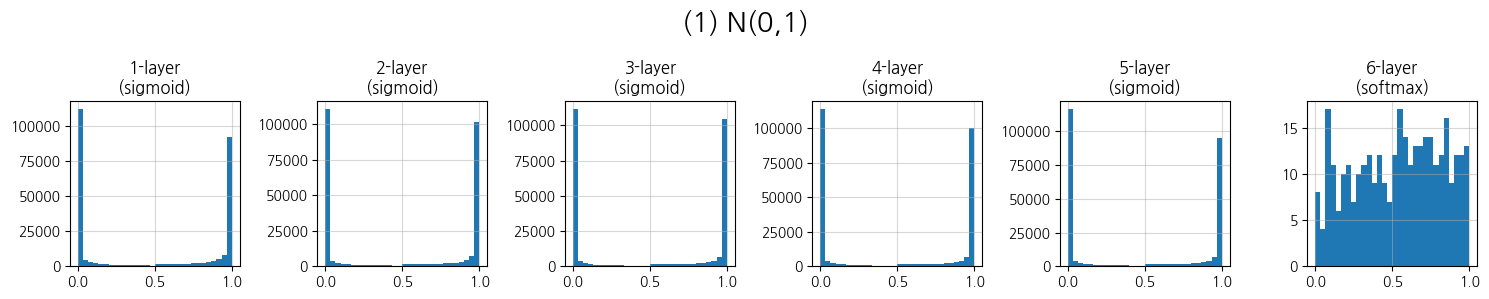

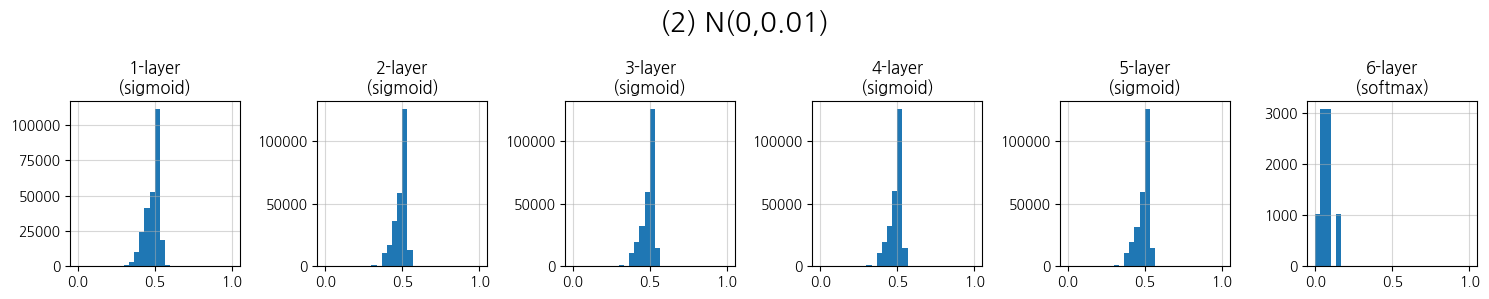

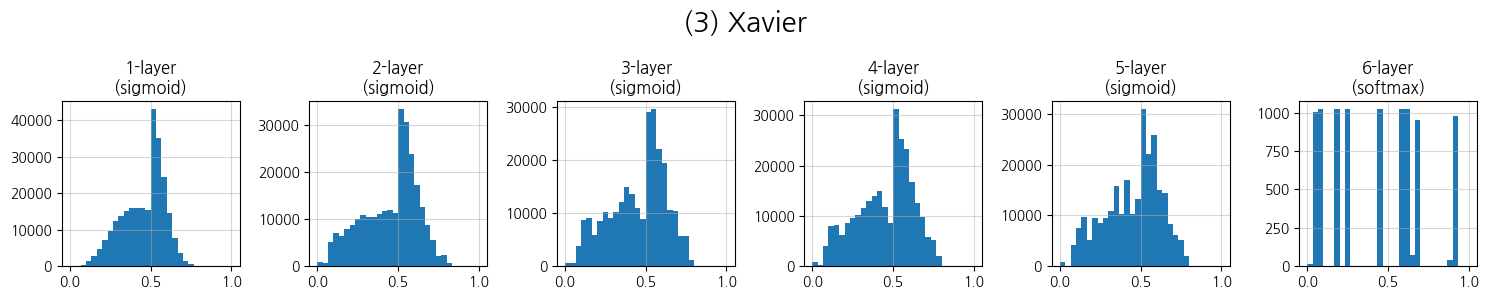

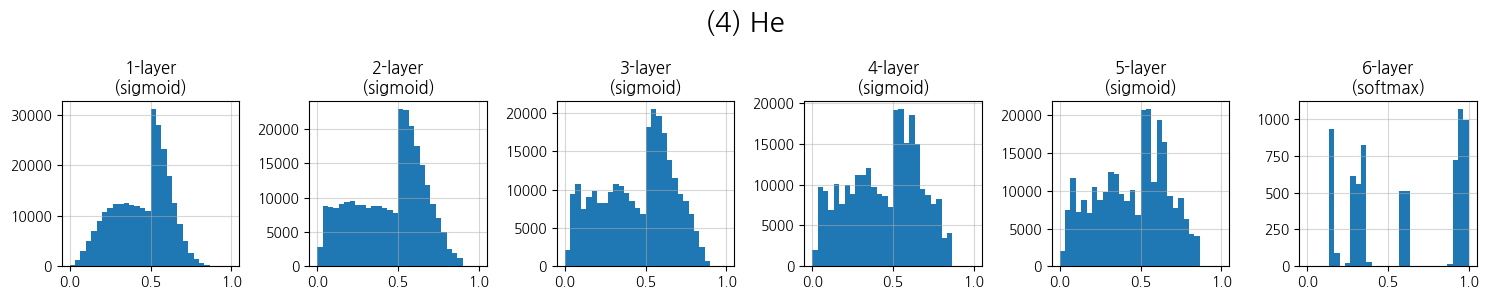

In [50]:
print('> Activation Function: Sigmoid')

# (1) N(0,1) + sigmoid
model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='sigmoid', weight_init_method=None, weight_init_limit=1)
_, activations = model.predict_numerical_gradient(X_batch, return_activations=True)

fig = plt.figure(figsize=(15,3))
for i,activation in enumerate(activations):
    fig.add_subplot(1, len(activations), i+1)
    plt.hist(activation.flatten(), bins=30, range=(0,1))
    plt.grid(alpha=0.5)
    if i+1 == len(activations):
        plt.title(f'{i+1}-layer\n(softmax)')
    else:
        plt.title(f'{i+1}-layer\n(sigmoid)')
plt.suptitle('(1) N(0,1)', fontsize=20)
plt.tight_layout()
plt.show()

# (2) N(0,0.01) + sigmoid
model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='sigmoid', weight_init_method=None, weight_init_limit=0.01)
_, activations = model.predict_numerical_gradient(X_batch, return_activations=True)

fig = plt.figure(figsize=(15,3))
for i,activation in enumerate(activations):
    fig.add_subplot(1, len(activations), i+1)
    plt.hist(activation.flatten(), bins=30, range=(0,1))
    plt.grid(alpha=0.5)
    if i+1 == len(activations):
        plt.title(f'{i+1}-layer\n(softmax)')
    else:
        plt.title(f'{i+1}-layer\n(sigmoid)')
plt.suptitle('(2) N(0,0.01)', fontsize=20)
plt.tight_layout()
plt.show()

# (3) Xavier + sigmoid
model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='sigmoid', weight_init_method='Xavier')
_, activations = model.predict_numerical_gradient(X_batch, return_activations=True)

fig = plt.figure(figsize=(15,3))
for i,activation in enumerate(activations):
    fig.add_subplot(1, len(activations), i+1)
    plt.hist(activation.flatten(), bins=30, range=(0,1))
    plt.grid(alpha=0.5)
    if i+1 == len(activations):
        plt.title(f'{i+1}-layer\n(softmax)')
    else:
        plt.title(f'{i+1}-layer\n(sigmoid)')
plt.suptitle('(3) Xavier', fontsize=20)
plt.tight_layout()
plt.show()

# (4) He + sigmoid
model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='sigmoid', weight_init_method='He')
_, activations = model.predict_numerical_gradient(X_batch, return_activations=True)

fig = plt.figure(figsize=(15,3))
for i,activation in enumerate(activations):
    fig.add_subplot(1, len(activations), i+1)
    plt.hist(activation.flatten(), bins=30, range=(0,1))
    plt.grid(alpha=0.5)
    if i+1 == len(activations):
        plt.title(f'{i+1}-layer\n(softmax)')
    else:
        plt.title(f'{i+1}-layer\n(sigmoid)')
plt.suptitle('(4) He', fontsize=20)
plt.tight_layout()
plt.show()

> Activation Function: ReLU


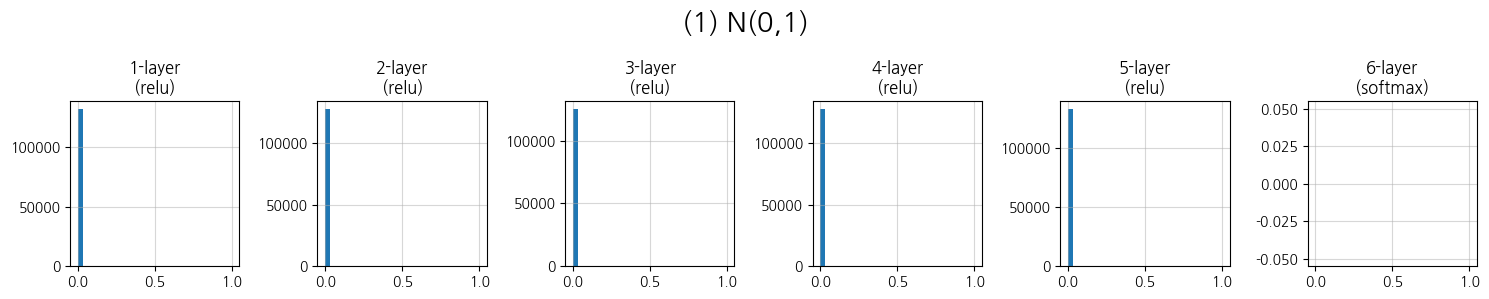

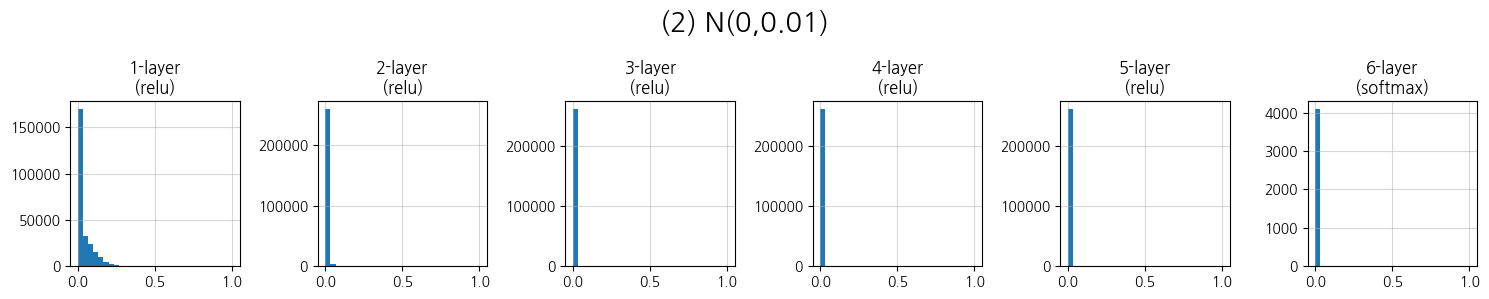

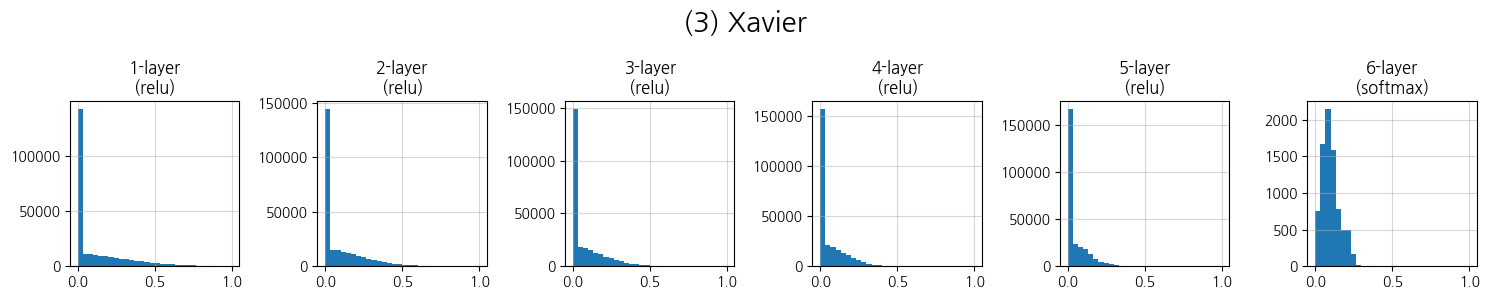

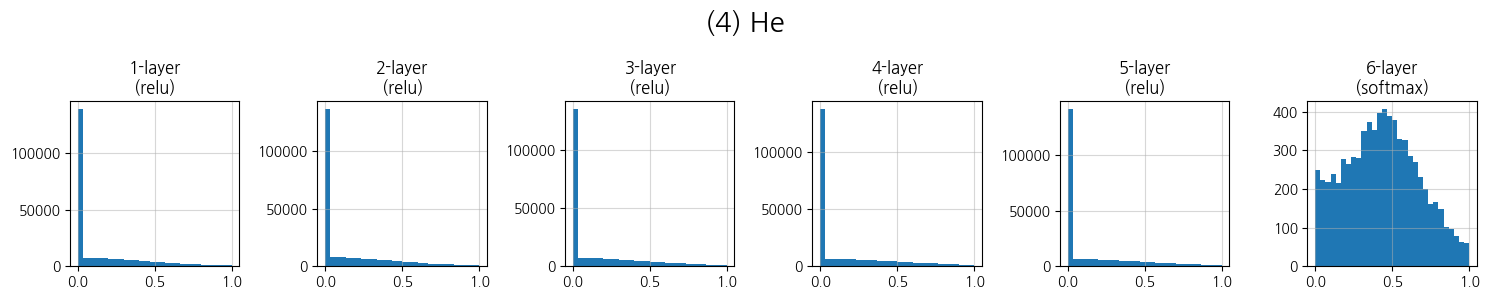

In [51]:
print('> Activation Function: ReLU')

# (1) N(0,1) + ReLU
model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='relu', weight_init_method=None, weight_init_limit=1)
_, activations = model.predict_numerical_gradient(X_batch, return_activations=True)

fig = plt.figure(figsize=(15,3))
for i,activation in enumerate(activations):
    fig.add_subplot(1, len(activations), i+1)
    plt.hist(activation.flatten(), bins=30, range=(0,1))
    plt.grid(alpha=0.5)
    if i+1 == len(activations):
        plt.title(f'{i+1}-layer\n(softmax)')
    else:
        plt.title(f'{i+1}-layer\n(relu)')
plt.suptitle('(1) N(0,1)', fontsize=20)
plt.tight_layout()
plt.show()

# (2) N(0,0.01) + ReLU
model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='relu', weight_init_method=None, weight_init_limit=0.01)
_, activations = model.predict_numerical_gradient(X_batch, return_activations=True)

fig = plt.figure(figsize=(15,3))
for i,activation in enumerate(activations):
    fig.add_subplot(1, len(activations), i+1)
    plt.hist(activation.flatten(), bins=30, range=(0,1))
    plt.grid(alpha=0.5)
    if i+1 == len(activations):
        plt.title(f'{i+1}-layer\n(softmax)')
    else:
        plt.title(f'{i+1}-layer\n(relu)')
plt.suptitle('(2) N(0,0.01)', fontsize=20)
plt.tight_layout()
plt.show()

# (3) Xavier + ReLU
model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='relu', weight_init_method='Xavier')
_, activations = model.predict_numerical_gradient(X_batch, return_activations=True)

fig = plt.figure(figsize=(15,3))
for i,activation in enumerate(activations):
    fig.add_subplot(1, len(activations), i+1)
    plt.hist(activation.flatten(), bins=30, range=(0,1))
    plt.grid(alpha=0.5)
    if i+1 == len(activations):
        plt.title(f'{i+1}-layer\n(softmax)')
    else:
        plt.title(f'{i+1}-layer\n(relu)')
plt.suptitle('(3) Xavier', fontsize=20)
plt.tight_layout()
plt.show()

# (4) He + ReLU
model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='relu', weight_init_method='He')
_, activations = model.predict_numerical_gradient(X_batch, return_activations=True)

fig = plt.figure(figsize=(15,3))
for i,activation in enumerate(activations):
    fig.add_subplot(1, len(activations), i+1)
    plt.hist(activation.flatten(), bins=30, range=(0,1))
    plt.grid(alpha=0.5)
    if i+1 == len(activations):
        plt.title(f'{i+1}-layer\n(softmax)')
    else:
        plt.title(f'{i+1}-layer\n(relu)')
plt.suptitle('(4) He', fontsize=20)
plt.tight_layout()
plt.show()

In [52]:
# batch normalization : 212p
# -> https://github.com/WegraLee/deep-learning-from-scratch/blob/3e4f6368b17ee4159c820197426eefb0b1315a9b/common/layers.py#L114
class BatchNormalization:
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None, eps=1e-6):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.eps = eps

        # 합성곱 계층은 4차원, 완전연결 계층은 2차원
        self.input_shape = None

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def __reshape(self, x):
        if x.ndim != 2:
            # (batch_size, channel, height, width)
            # - channel: RGB(3), Gray(1)
            # - height, width : height, width of image (64x64 or 256x256)
            N, C, H, W = x.shape 
            x = x.reshape(N, -1)
        return x

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            # N: batch size, D: input size(feature size)
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = np.mean(x, axis=0)
            xc = x - mu                  # centered
            var = np.mean(xc**2, axis=0) # (mu, xc, xn)에 대한 정보를 얻기위해서 np.std를 사용하지 않고 분산공식으로 계산
            std = np.sqrt(var + self.eps)
            xn = xc / std                # normalized

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std

            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var  = self.momentum * self.running_var  + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / np.sqrt(self.running_var + self.eps)

        # (x-mu)/std의 inverse transform = scale * normalized + shift
        out = self.gamma * xn + self.beta

        return out

    def forward(self, x, train_flg):
        self.input_shape = x.shape

        x = self.__reshape(x)
        out = self.__forward(x, train_flg)
        out = out.reshape(*self.input_shape)

        return out
        
    def __backward(self, dout):
        # backward by Chain Rule
        # - (역전파 그림 참조) https://velog.io/@clayryu328/밑바닥부터-시작하는-딥러닝-13-배치정규화
        #   -> (4번, 6번에서 참조하면 좋음)

        # (1) y = gamma * xn + beta
        dbeta = np.sum(dout, axis=0)            #-> dL/dbeta = dL/dy * dy/dbeta = dL/dy * 1 = dL/dy
        dgamma = np.sum(dout * self.xn, axis=0) #-> dL/dgamma = dL/dy * dy/dgamma = dL/dy * xn
        # print(dgamma[:3])
        dxn = dout * self.gamma                 #-> dL/dxn = dL/dy * dy/dxn = dL/dy * gamma

        # (2) xn = xc / std
        dstd = - np.sum(dxn * self.xc / (self.std**2), axis=0) #-> dL/dstd = dL/dxn * dxn/dstd = dL/dxn * xc * -(1/std)**2
        
        # (3) std = var**(1/2)
        dvar = dstd * 0.5 / self.std #dL/dvar = dL/dstd * dstd/dvar = dL/dstd * (1/2) * var**(-1/2) = dL/dstd * (1/2) * (1/std)

        # (4) var = 1/n * sum(xc**2)
        #  두개의 xc가 합류를 하기 때문에 더해준다
        #  (4-1) xn = xc / std           -> dL/dxc = dL/dxn * dxn/dxc = dL/dxn * (1/std)
        #  (4-2) var = 1/n * sum(xc**2)  -> dL/dxc = dL/dvar * dvar/dxc = dL/dvar * (2/n) * xc
        dxc = (dxn / self.std) + (dvar * (2.0/self.batch_size) * self.xc)

        # (5) xc = x - mu
        dmu = np.sum(dxc, axis=0) # dL/dmu = dL/dxc * dxc/dmu = dL/dxc * 1 = dL/dxc

        # (6) xc와 mu의 평균이 합류를 하기 때문에 더해준다
        #  (6-1) xc = x - mu        -> dL/dx = dL/dxc * dxc/dx = dL/dxc * 1 = dL/dxc
        #  (6-2) mu = 1/N * sum(x)  -> dL/dx = dL/dmu * dmu/dx = dL/dmu * (1/N)
        dx = dxc - (dmu / self.batch_size)

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx

    def backward(self, dout):
        dout = self.__reshape(dout)
        dout = self.__backward(dout)
        dout = dout.reshape(*self.input_shape)
        return dout

In [53]:
# dropout : 219p
class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_rate # dropout_rate보다 높은건(삭제안할거) True, 낮은건(삭제할거) False
            return x * self.mask # dropout_rate보다 높은건 그대로 보내고, 낮은건 0으로 없앰
        else:
            return x * (1.0 - self.dropout_rate) # 모든 뉴런을 활성화하되, 훈련 시의 비활성화된 뉴런을 고려하여 값을 "보정"해야함. 이때, 1 - dropout_rate로 보정하는 것이 일반적임.
                                                 # dropout_rate 만큼 감소되었다고 치고 보정함.

    def backward(self, dout):
        return dout * self.mask

In [54]:
from tqdm import tqdm, trange
from collections import OrderedDict
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

class MultiLayerNet:
    def __init__(self, input_size, output_size, hidden_sizes, activation=None, weight_init_method='auto',
                 dropout=None, weight_decay_lambda=0, random_state=42, batchnorm=False):

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.activation = str(activation).lower()
        self.weight_init_method = str(weight_init_method).lower()
        self.dropout = dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.batchnorm = batchnorm
        self.random_state = random_state

        assert self.activation in ['none','sigmoid','relu','leakyrelu'], "activation must be one of ['sigmoid','relu','leakyrelu'] or None."
        assert self.weight_init_method in ['auto','xavier','he','none'], "weight_init_method must be one of ['auto','Xavier','He',None]."
        assert (dropout is None) or (0<=dropout<=1), "dropout must be between 0 and 1 or None."

        self.node_sizes = [input_size] + hidden_sizes + [output_size]
        self.n_layers = len(self.node_sizes)-1

        # activation
        self.activation_function = self.__activation_init()

        # define layers
        self.__layers_init()

    def __activation_init(self):
        if self.activation=='none':
            self.activation = 'sigmoid'

        activation_dict = {
            'sigmoid' : Sigmoid(),
            'relu' : ReLU(),
            'leakyrelu' : LeakyReLU(),
        }
        return activation_dict.get(self.activation)

    def __layers_init(self):
        if self.weight_init_method=='auto':
            if self.activation=='sigmoid':
                self.weight_init_method = 'xavier'
            elif self.activation in ['relu','leakyrelu']:
                self.weight_init_method = 'he'
        elif self.weight_init_method=='none':
            self.weight_init_method = None

        self.params = {'weights': OrderedDict(), 'biases': OrderedDict(), 'gamma': OrderedDict(), 'beta': OrderedDict()}
        self.layers = OrderedDict()
        for i in range(self.n_layers):
            is_last = (i+1 == self.n_layers)
            input_dim = self.node_sizes[i]
            output_dim = self.node_sizes[i+1]

            # Affine
            self.layers[f'Affine{i+1}'] = Affine(input_dim, output_dim, self.weight_init_method)
            self.params['weights'][f'w{i+1}'] = self.layers[f'Affine{i+1}'].weight
            self.params['biases'] [f'b{i+1}'] = self.layers[f'Affine{i+1}'].bias

            # Batch Normalization
            if (self.batchnorm) and (not is_last):
                self.params['gamma'][f'g{i+1}'] = np.ones(output_dim)
                self.params['beta'] [f'b{i+1}'] = np.zeros(output_dim)
                self.layers[f'BatchNorm{i+1}'] = BatchNormalization(self.params['gamma'][f'g{i+1}'], self.params['beta'] [f'b{i+1}'])

            # Activation
            if not is_last:
                self.layers[f'Activation{i+1}'] = deepcopy(self.activation_function)

            # Dropout
            if (self.dropout is not None) and (not is_last):
                self.layers[f'Dropout{i+1}'] = Dropout(self.dropout)

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if ("dropout" in key.lower()) or ("batchnorm" in key.lower()):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, y_true, train_flg=False):
        logits = self.predict(x, train_flg)

        # weight decay (L2 정규화) : 217p
        # -> https://github.com/WegraLee/deep-learning-from-scratch/blob/3e4f6368b17ee4159c820197426eefb0b1315a9b/common/multi_layer_net_extend.py#L91
        # -> 큰 가중치에 대해서 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제
        weight_decay = 0
        for i in range(self.n_layers):
            W = self.params['weights'][f'w{i+1}']
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        loss = self.last_layer.forward(y=logits, t=y_true) + weight_decay
        
        return loss

    def accuracy(self, x, y_true):
        logits = self.predict(x, train_flg=False)
        y_pred = np.argmax(logits, axis=1)
        if y_true.ndim != 1:
            y_true = np.argmax(y_true, axis=1)

        acc = np.sum(y_true==y_pred) / float(x.shape[0])
        
        return acc

    def gradient(self, x, y_true):
        # 순전파
        self.loss(x, y_true, train_flg=True)

        # 역전파
        dout = self.last_layer.backward()
        for key, layer in reversed(self.layers.items()):
            dout = layer.backward(dout)

        # params 저장
        params = {'weights': OrderedDict(), 'biases': OrderedDict(), 'gamma': OrderedDict(), 'beta': OrderedDict()}
        for i in range(self.n_layers):
            is_last = (i+1 == self.n_layers)
            params['weights'][f'w{i+1}'] = self.layers[f'Affine{i+1}'].dW + (self.weight_decay_lambda * self.params['weights'][f'w{i+1}'])
            params['biases'] [f'b{i+1}'] = self.layers[f'Affine{i+1}'].db
            if self.batchnorm and (not is_last):
                params['gamma'][f'g{i+1}'] = self.layers[f'BatchNorm{i+1}'].dgamma
                params['beta'] [f'b{i+1}'] = self.layers[f'BatchNorm{i+1}'].dbeta

        return params

    def gradient_update(self, params):
        # params update
        self.params = params

        # Affine weight update
        for k in range(self.n_layers):
            weight = params['weights'][f'w{k+1}']
            bias = params['biases'] [f'b{k+1}']
            self.layers[f'Affine{k+1}'].update(weight,bias)

In [55]:
# epochs = 100
# batch_size = 64
# lr = 0.01

# input_size = 784
# output_size = 10
# hidden_sizes = [8]

# model = MultiLayerNet(input_size, output_size, hidden_sizes, activation='LeakyReLU', dropout=0.5, weight_decay_lambda=1e-5, batchnorm=True)
# optimizer = SGD(lr=lr) # SGD, Momentum, AdaGrad, RMSProp, Adam

# X_batches, y_batches = batch_split(X_train, y_train, batch_size, shuffle=True, random_state=42)

# elapsed_times = []
# for i in range(epochs):
#     start_time = time.time()

#     train_loss = 0
#     val_loss = 0

#     train_acc = 0
#     val_acc = 0

#     # get mini-batch (실제로는 모든 6만개의 데이터에 대해서 모두 가중치 업데이트를 해야 1개의 epoch로 쳐줌)
#     pbar_batch = tqdm(zip(X_batches, y_batches), total=len(X_batches))
#     for X_batch, y_batch in pbar_batch:
#         # calculate gradients
#         grads = model.gradient(X_batch, y_batch)

#         # gradient descent
#         params = optimizer.update(model.params, grads)

#         # gradient update
#         model.gradient_update(params)

#         # loss
#         train_loss += model.loss(X_batch, y_batch, train_flg=False)
#         val_loss   += model.loss(X_test , y_test , train_flg=False)

#         # acc
#         train_acc += model.accuracy(X_batch, y_batch)
#         val_acc   += model.accuracy(X_test , y_test)

#     # calculate loss
#     train_loss /= len(X_batches)
#     val_loss /= len(X_batches)

#     # calculate accuracy
#     train_acc /= len(X_batches)
#     val_acc /= len(X_batches)

#     # progress
#     now_time = str(datetime.datetime.now())[:-7]
#     end_time = time.time()
#     elapsed = end_time-start_time
#     elapsed_times.append(elapsed)
#     total = sum(elapsed_times)
#     remaining = (epochs-i-1) * elapsed

#     str_i = str(i+1).zfill(len(str(epochs)))
#     progress = f'{now_time} | [{str_i}/{epochs}] {train_loss=:.4f}, {val_loss=:.4f}, {train_acc=:.4f}, {val_acc=:.4f}, {elapsed=:.1f}s, {total=:.1f}s, {remaining=:.1f}s'
#     print(progress)

In [56]:
# # im2col 구현 : 245p, https://github.com/WegraLee/deep-learning-from-scratch/blob/3e4f6368b17ee4159c820197426eefb0b1315a9b/common/util.py#L39
# def im2col(input_data, FH, FW, stride=1, pad=0):
#     N, C, H, W = input_data.shape

#     # 출력크기가 정수가 아니더라도 에러가 발생하지않도록
#     OH = 1 + (H + 2*pad - FH) // stride
#     OW = 1 + (W + 2*pad - FW) // stride

#     # 1번째축(N), 2번째축(C)에는 padding을 하지 않고, 3번째축(H), 4번째축(W)에는 padding을 한다.
#     # 'constant'는 0을 넣는다는 의미 (contstant_values default=0)
#     pad_width = [
#         (0,0),      # axis=0
#         (0,0),      # axis=1
#         (pad, pad), # axis=2
#         (pad, pad), # axis=3
#     ]
#     img = np.pad(input_data, pad_width, mode='constant')

#     # (H,W) 크기를 stride, pad와 (FH,FW)의 크기의 필터로 자르면 (OH,OW) 크기로 만들어짐
#     # -> batch size와 channels는 유지
#     col = np.zeros(shape=(N, C, FH, FW, OH, OW))

#     # end = start + stride * output size 인 이유
#     # -> end는 filter가 시작 지점 hs에서 slicing하여 최대로 도달할 위치
#     # -> 즉, hs에서 시작해서 filter가 stride 간격으로 out_h번 이동한다는 의미
#     for hs in range(FH):
#         he = hs + stride * OH
#         for ws in range(FW):
#             we = ws + stride * OW
#             col[:, :, hs, ws, :, :] = img[:, :, hs:he:stride, ws:we:stride]

#     # (N, C, FH, FW, OH, OW)를 (N*OH*OW, C*FH*FW) 형태로 변환
#     col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*OH*OW, C*FH*FW)

#     return col

In [57]:
# im2col, col2im 구현 : 245p, https://github.com/WegraLee/deep-learning-from-scratch/blob/3e4f6368b17ee4159c820197426eefb0b1315a9b/common/util.py#L39
import warnings
def calculate_output_dim(input_size, kernel_size, stride, padding):
    # is_warn = (input_size + 2*padding - kernel_size) % stride != 0
    # if is_warn:
    #     warnings.warn(
    #         "The output dimension is not an integer due to the chosen padding, kernel size, or stride. "
    #         "This may cause the output size to differ from the intended shape. Consider adjusting "
    #         "these values to ensure integer output dimensions."
    #     )
    # 출력크기가 정수가 아니더라도 에러가 발생하지않도록 처리
    output_size = 1 + (input_size + 2*padding - kernel_size) // stride
    return output_size

def val2list(val, name, dimension):
    if isinstance(val, int):
        val_list = [val] * dimension
    elif isinstance(val, str):
        pass
    else:
        assert len(val) == dimension, f"Expected {name} to have length {dimension}, but got {len(val)}"
        val_list = list(val)
    return val_list

def im2col(input_data, kernel_size, stride=1, padding=0, dimension=2):
    kernel_spatial_dim = val2list(kernel_size, 'kernel_size', dimension)
    stride = val2list(stride, 'stride', dimension)
    padding = val2list(padding, 'padding', dimension)

    # get input shape : (N, C, D, H, W, ...) = (N, C, *input)
    dim = input_data.shape
    N, C, input_spatial_dim = dim[0], dim[1], dim[2:]

    # get output shape and get pad width for padding
    # -> 1번째축(N), 2번째축(C)에는 padding을 하지 않고, 3번째축(Depth, Height, Width, ...) 부터는 padding을 한다.
    pad_width = [(0,0),(0,0)]
    output_spatial_dim = []
    for i in range(len(input_spatial_dim)):
        output_size = calculate_output_dim(input_spatial_dim[i], kernel_spatial_dim[i], stride[i], padding[i])
        output_spatial_dim.append(output_size)
        pad_width.append((padding[i],padding[i])) # (앞쪽 패딩, 뒤쪽 패딩)

    # padding the input data
    # -> padded img shape: (N, C, D+2p, H+2p, W+2p, ...) = (N, C, *input+2p)
    # -> 'constant'는 0을 넣는다는 의미 (contstant_values default=0)
    img = np.pad(input_data, pad_width, mode='constant')

    # initialize the column
    # -> col: (N, C, *kernel, *out) = (N, C, FD, FH, FW, ..., OD, OH, OW, ...)
    # -> (H,W) 크기를 stride & padding과 (FH,FW)의 크기의 필터로 자르면 (OH,OW) 크기로 만들어짐
    # -> batch size와 channels는 유지
    col_dim = [N, C] + kernel_spatial_dim + output_spatial_dim
    col = np.zeros(shape=col_dim)

    for idx in np.ndindex(*kernel_spatial_dim):
        slices_img = [slice(None), slice(None)]             # img slices : N, C 차원 슬라이싱은 그대로 유지 -> [:, :]
        slices_col = [slice(None), slice(None)] + list(idx) # col slices : N, C 및 각 filter 차원 슬라이싱 -> [:, :, depth, height, weight, ...]
        
        for start, output_size in zip(idx, output_spatial_dim):
            end = start + stride[i] * output_size
            slices_img.append(slice(start, end, stride[i])) # img slices : [:, :, start:end:stride]
            slices_col.append(slice(None))               # col slices : [:, :, depth, height, weight, ...,  :]

        col[tuple(slices_col)] = img[tuple(slices_img)]

    # (N, C, *kernel, *out)를 (N x *out, C x *kernel) 형태로 변환
    # -> lenght of *kernel or *out = dimension
    kernel_dim_indices = range(col.ndim)[2:2+dimension] # kernel dim indices : batch size, channel을 제외한 2부터 시작
    output_dim_indices = range(col.ndim)[2+dimension:]  # output dim indices : kernel dim indices 이후부터

    col = col.transpose(0, *output_dim_indices, 1, *kernel_dim_indices) # 0: batch size, 1: channels
    col = col.reshape(N * np.prod(output_spatial_dim), C * np.prod(kernel_spatial_dim))

    return col

def col2im(col, input_shape, kernel_size, stride=1, padding=0, dimension=2):
    kernel_spatial_dim = val2list(kernel_size, 'kernel_size', dimension)
    stride = val2list(stride, 'stride', dimension)
    padding = val2list(padding, 'padding', dimension)

    # get input shape
    N, C, input_spatial_dim = input_shape[0], input_shape[1], input_shape[2:]

    # get output shape
    output_spatial_dim = []
    for i in range(len(input_spatial_dim)):
        output_size = calculate_output_dim(input_spatial_dim[i], kernel_spatial_dim[i], stride[i], padding[i])
        output_spatial_dim.append(output_size)

    # (N x *out, C x *kernel)를 (N, C, *kernel, *out) 형태로 변환
    col = col.reshape(N, *output_spatial_dim, C, *kernel_spatial_dim)
    channel_dim_order = len(output_spatial_dim)+1     # channel dim order : N, output spatial dim 이후
    output_dim_order = range(col.ndim)[1:1+dimension] # output dim order  : batch size 이후에 dimension 만큼
    kernel_dim_order = range(col.ndim)[2+dimension:]  # kernel dim order  : batch size, channel, output spatial dim 이후
    col = col.transpose(0, channel_dim_order, *kernel_dim_order, *output_dim_order)

    # input_size : 기존의 input feature map size
    # 2*padding : 양쪽에 padding된 공간
    img_spatial_dim = [(input_size + 2*padding[i]) for i,input_size in enumerate(input_spatial_dim)]

    img = np.zeros((N, C, *img_spatial_dim))
    count = np.zeros_like(img)
    for idx in np.ndindex(*kernel_spatial_dim):
        slices_img = [slice(None), slice(None)]             # img slices : N, C 차원 슬라이싱은 그대로 유지 -> [:, :]
        slices_col = [slice(None), slice(None)] + list(idx) # col slices : N, C 및 각 filter 차원 슬라이싱 -> [:, :, depth, height, weight, ...]
        
        for start, output_size in zip(idx, output_spatial_dim):
            end = start + stride[i] * output_size
            slices_img.append(slice(start, end, stride[i])) # img slices : [:, :, start:end:stride]
            slices_col.append(slice(None))               # col slices : [:, :, depth, height, weight, ...,  :]

        img[tuple(slices_img)] += col[tuple(slices_col)]
        count[tuple(slices_img)] += 1

    # 필터 적용 횟수로 나누어 겹치는 영역을 평균화
    count[count == 0] = 1
    img /= count

    # 패딩을 제외한 원본 크기의 영역(padding:dim+padding)을 선택
    slices_cropped = [slice(padding[i], dim+padding[i]) for i,dim in enumerate(input_spatial_dim)]
    img_cropped = img[(slice(None), slice(None), *slices_cropped)]

    return img_cropped

In [58]:
kernel_size = (4,4)
stride = 2 #(2,2)
padding = 2 #(2,2)

input_data = np.random.rand(100, 3, 28, 28)

# (2-1) forward (im2col)
#  - OH, OW = 1 + (28 + 2*1 - 4) // 2 = 14
#  - (N*OH*OW, C*FH*FW) = (100*14*14, 3*4*4) = (19_600, 48)
col = im2col(input_data, kernel_size, stride, padding, dimension=2)
print(col.shape)

# (2-2) backward (col2im)
#  - input_data와 shape가 같음
img = col2im(col, input_data.shape, kernel_size, stride, padding, dimension=2)
print(img.shape)

# check
np.allclose(img, input_data)

(22500, 48)
(100, 3, 28, 28)


True

In [59]:
# Convolution Layer 구현 : 246p
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, weight_init_method=None):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = val2list(kernel_size, 'kernel_size', dimension=2)
        self.stride = val2list(stride, 'stride', dimension=2)
        self.padding = val2list(padding, 'padding', dimension=2)
        self.weight_init_method = str(weight_init_method).lower()

        self.weight_init(method=self.weight_init_method)

    def weight_init(self, method=None, seed=42):
        np.random.seed(seed)

        if method is None:
            limit = 0.01
        elif method == 'xavier':
            limit = np.sqrt(2 / (self.in_channels + self.out_channels)) # Xavier initialization
        elif method == 'he':
            limit = np.sqrt(2 / self.in_channels)                       # He initialization
        else:
            raise ValueError

        self.weight = np.random.uniform(-limit, limit, (self.out_channels, self.in_channels, *self.kernel_size))
        self.bias = np.random.uniform(-limit, limit, self.out_channels)

    def forward(self, x):
        self.x = x
        FN, C, FH, FW = self.weight.shape
        N, C, H, W = self.x.shape

        OH = calculate_output_dim(H, FH, self.stride[0], self.padding[0])
        OW = calculate_output_dim(W, FW, self.stride[1], self.padding[1])

        self.col = im2col(self.x, self.kernel_size, self.stride, self.padding, dimension=2)

        # col    : (N*OH*OW, C*FH*FW)
        # weight : (FN, C, FH, FW) -> (C*FH*FW, FN)
        # out    : (N*OH*OW, FN) -> (N, OH, OW, FN) -> (N, FN, OH, OW)
        out = self.col @ self.weight.reshape(FN, C*FH*FW).T + self.bias
        out = out.reshape(N, OH, OW, self.out_channels).transpose(0, 3, 1, 2)

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.weight.shape
        N, FN, OH, OW = dout.shape

        # dout : (N, FN, OH, OW) -> (N, OH, OW, FN) -> (N*OH*OW, FN)
        dout = dout.transpose(0, 2, 3, 1).reshape(N*OH*OW, FN)

        # dW, db, dX 계산은 Affine Class 참조
        self.dW = self.col.T @ dout                             # col: (C*FH*FW, N*OH*OW), dout: (N*OH*OW, FN), dW: (C*FH*FW, FN)
        self.dW = self.dW.transpose(1,0).reshape(FN, C, FH, FW) # dW: (C*FH*FW, FN) -> (FN, C, FH, FW)
        self.db = np.sum(dout, axis=0)
        
        dcol = dout @ self.weight.reshape(FN, C*FH*FW)  # dout: (N*OH*OW, FN), W: (FN, C*FH*FW), dcol: (N*OH*OW, C*FH*FW)
        dx = col2im(dcol, self.x.shape, self.kernel_size, self.stride, self.padding, dimension=2) # dx: (N, C, H, W)

        return dx

    def update(self, weight, bias):
        self.weight = weight
        self.bias = bias

In [60]:
# initial setting
N, C, H, W = 100, 3, 28, 28
FN = 16
kernel_size = 4
stride = 2
padding = 2

# prepare dataset
input_data = np.random.rand(N, C, H, W)

# forward
conv1 = Conv2d(in_channels=C, out_channels=FN, kernel_size=kernel_size, stride=stride, padding=padding, weight_init_method='Xavier')
print('> forward shape: (N, FN, OH, OW) =', conv1.forward(input_data).shape)

# backward
OH = calculate_output_dim(H, kernel_size, stride, padding)
OW = calculate_output_dim(W, kernel_size, stride, padding)
dout = np.random.rand(N, FN, OH, OW)
print('> backward shape: (N, C, H, W) =', conv1.backward(dout).shape)

> forward shape: (N, FN, OH, OW) = (100, 16, 15, 15)
> backward shape: (N, C, H, W) = (100, 3, 28, 28)


In [61]:
class MaxPool2d:
    def __init__(self, kernel_size, stride=1, padding=0):
        self.kernel_size = val2list(kernel_size, 'kernel_size', dimension=2)
        self.stride = val2list(stride, 'stride', dimension=2)
        self.padding = val2list(padding, 'padding', dimension=2)

    def forward(self, x):
        self.x = x
        N, C, H, W = self.x.shape
        FH, FW = self.kernel_size

        OH = calculate_output_dim(H, FH, self.stride[0], self.padding[0])
        OW = calculate_output_dim(W, FW, self.stride[1], self.padding[1])

        # col: (N*OH*OW, C*FH*FW) -> (N*C*OH*OW, FH*FW)
        self.col = im2col(self.x, self.kernel_size, self.stride, self.padding, dimension=2)
        self.col = self.col.reshape(N*C*OH*OW, FH*FW)

        # out: (N*C*OH*OW, ) -> (N, OH, OW, C) -> (N, C, OH, OW)
        self.arg_max = np.argmax(self.col, axis=1)
        out = np.max(self.col, axis=1) # pooling axis(FH*FW)에 대해서 최대값을 가져옴
        out = out.reshape(N, OH, OW, C)
        out = out.transpose(0, 3, 1, 2)

        return out

    def backward(self, dout):
        N, C, OH, OW = dout.shape
        FH, FW = self.kernel_size

        # dout: (N, C, OH, OW) -> (N, OH, OW, C)
        dout = dout.transpose(0, 2, 3, 1)

        # dmax: (N*C*OH*OW, FH*FW) -> (N, OH, OW, C, FH*FW)
        dmax = np.zeros((N*C*OH*OW, FH*FW))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten() # 정렬된 순서대로 값을 끼워맞춤
        dmax = dmax.reshape(N, OH, OW, C, FH*FW)

        # dcol: (N*OH*OW, C*FH*FW)
        dcol = dmax.reshape(N*OH*OW, C*FH*FW)

        # dx: (N, C, FH, FW, OH, OW)
        dx = col2im(dcol, self.x.shape, self.kernel_size, self.stride, self.padding, dimension=2)

        return dx

In [62]:
# initial setting
n_label = 10
N, C, H, W = 100, 3, 28, 28
t = np.random.rand(N, n_label)

FN = 16
conv_kernel_size = 4
conv_stride = 2
conv_padding = 2

pool_kernel_size = 2
pool_stride = 2
pool_padding = 2

# prepare dataset
input_data = np.random.rand(N, C, H, W)

# (1) Forward
print('> Forward')

# (1-1) Conv2d
conv1 = Conv2d(in_channels=C, out_channels=FN, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, weight_init_method='Xavier')
out1 = conv1.forward(input_data)
print(' - Conv2d forward shape: (N, FN, OH, OW) =', out1.shape)

# (1-2) ReLU
relu1 = ReLU()
out1 = relu1.forward(out1)
print(' - ReLU')

# (1-3) MaxPool2d
maxpool1 = MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)
# maxpool1 = Pooling(pool_kernel_size, pool_kernel_size, pool_stride, pool_padding)
out1 = maxpool1.forward(out1)
print(' - MaxPool2d: (N, C=FN, OH, OW) =', out1.shape)

# (1-4) Affine
in_features = np.prod(out1.shape[1:])
affine1 = Affine(in_features, in_features//10)
out1 = affine1.forward(out1)
print(' - Affine: (N, (C*OH*OW)//10) =', out1.shape)

# (1-5) ReLU
relu2 = ReLU()
out1 = relu2.forward(out1)
print(' - ReLU')

# (1-6) Affine
in_features = out1.shape[1]
affine2 = Affine(in_features, n_label)
out1 = affine2.forward(out1)
print(' - Affine: (N, n_label) =', out1.shape)

# (1-7) SoftmaxWithLoss
last_layer = SoftmaxWithLoss()
loss = last_layer.forward(out1, t)
print(' - SoftmaxWithLoss:', loss)

> Forward
 - Conv2d forward shape: (N, FN, OH, OW) = (100, 16, 15, 15)
 - ReLU
 - MaxPool2d: (N, C=FN, OH, OW) = (100, 16, 9, 9)
 - Affine: (N, (C*OH*OW)//10) = (100, 129)
 - ReLU
 - Affine: (N, n_label) = (100, 10)
 - SoftmaxWithLoss: 2.3006325254255597


In [63]:
# (2) Backward
print('> Backward')

# (2-1) SoftWithLoss
dout1 = last_layer.backward()
print(' - SoftmaxWithLoss:', dout1.shape)

# (2-2) Affine
dout1 = affine2.backward(dout1)
print(' - Affine:', dout1.shape)

# (2-3) ReLU
dout1 = relu2.backward(dout1)
print(' - ReLU')

# (2-4) Affine
dout1 = affine1.backward(dout1)
print(' - Affine:', dout1.shape)

# (2-5) MaxPool2d
dout1 = maxpool1.backward(dout1)
print(' - MaxPool2d:', dout1.shape)

# (2-6) ReLU
dout1 = relu1.backward(dout1)
print(' - ReLU')

# (2-7) Conv2d
dout1 = conv1.backward(dout1)
print(' - Conv2d:', dout1.shape)

> Backward
 - SoftmaxWithLoss: (100, 10)
 - Affine: (100, 129)
 - ReLU
 - Affine: (100, 16, 9, 9)
 - MaxPool2d: (100, 16, 15, 15)
 - ReLU
 - Conv2d: (100, 3, 28, 28)


In [64]:
from tqdm import tqdm, trange
from collections import OrderedDict
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

class Flatten:
    def __init__(self):
        pass

    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(self.input_shape[0], -1)

    def backward(self, dout):
        return dout.reshape(self.input_shape)

class MultiLayerConvNet:
    def __init__(self, input_dim, output_size,
                 conv_num, filter_num, kernel_size, stride, padding, hidden_sizes,
                 activation=None, weight_init_method='auto',
                 dropout=None, weight_decay_lambda=0, random_state=42, batchnorm=False):
                 
        self.input_dim = input_dim
        self.output_size = output_size
        self.conv_num = conv_num
        self.filter_num = filter_num
        self.kernel_size = val2list(kernel_size, 'kernel_size', dimension=2)
        self.stride = val2list(stride, 'stride', dimension=2)
        self.padding = val2list(padding, 'padding', dimension=2)
        self.hidden_sizes = hidden_sizes
        self.activation = str(activation).lower()
        self.weight_init_method = str(weight_init_method).lower()
        self.dropout = dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.batchnorm = batchnorm
        self.random_state = random_state

        assert self.activation in ['none','sigmoid','relu','leakyrelu'], "activation must be one of ['sigmoid','relu','leakyrelu'] or None."
        assert self.weight_init_method in ['auto','xavier','he','none'], "weight_init_method must be one of ['auto','Xavier','He',None]."
        assert (dropout is None) or (0<=dropout<=1), "dropout must be between 0 and 1 or None."

        self.pool_kernel_size = (2,2)
        self.pool_stride = (2,2)
        self.pool_padding = (0,0)

        # Convolution + Affine(hidden) + Affine(label)
        self.n_layers = self.conv_num + len(self.hidden_sizes) + 1

        # activation
        self.activation_function = self.__activation_init()

        # define layers
        self.__layers_init()

    def __activation_init(self):
        if self.activation=='none':
            self.activation = 'sigmoid'

        activation_dict = {
            'sigmoid' : Sigmoid(),
            'relu' : ReLU(),
            'leakyrelu' : LeakyReLU(),
        }
        return activation_dict.get(self.activation)

    def __layers_init(self):
        if self.weight_init_method=='auto':
            if self.activation=='sigmoid':
                self.weight_init_method = 'xavier'
            elif self.activation in ['relu','leakyrelu']:
                self.weight_init_method = 'he'
        elif self.weight_init_method=='none':
            self.weight_init_method = None

        self.params = {'weights': OrderedDict(), 'biases': OrderedDict(), 'gamma': OrderedDict(), 'beta': OrderedDict()}
        self.layers = OrderedDict()

        output_size = self.input_dim[1:]
        for i in range(self.conv_num):
            is_last = (i+1 == self.n_layers)
            in_channels = self.input_dim[0] if i==0 else self.filter_num

            # Conv2d
            self.layers[f'Conv.{i+1}'] = Conv2d(
                in_channels=in_channels, out_channels=self.filter_num,
                kernel_size=self.kernel_size, stride=self.stride, padding=self.padding,
                weight_init_method=self.weight_init_method,
            )
            self.params['weights'][f'w{i+1}'] = self.layers[f'Conv.{i+1}'].weight
            self.params['biases'] [f'b{i+1}'] = self.layers[f'Conv.{i+1}'].bias
            output_size = [calculate_output_dim(output_size[i], self.kernel_size[i], self.stride[i], self.padding[i]) for i in range(2)]

            # # Batch Normalization
            # if (self.batchnorm) and (not is_last):
            #     self.params['gamma'][f'g{i+1}'] = np.ones(output_dim)
            #     self.params['beta'] [f'b{i+1}'] = np.zeros(output_dim)
            #     self.layers[f'BatchNorm{i+1}'] = BatchNormalization(self.params['gamma'][f'g{i+1}'], self.params['beta'] [f'b{i+1}'])

            # Activation
            if not is_last:
                self.layers[f'Activation.{i+1}'] = deepcopy(self.activation_function)

            self.layers[f'MaxPool.{i+1}'] = MaxPool2d(self.pool_kernel_size, stride=self.pool_stride, padding=self.pool_padding)
            output_size = [calculate_output_dim(output_size[i], self.pool_kernel_size[i], self.pool_stride[i], self.pool_padding[i]) for i in range(2)]

            # Dropout
            if (self.dropout is not None) and (not is_last):
                self.layers[f'Dropout.{i+1}'] = Dropout(self.dropout)

        self.layers[f'Flatten.{self.conv_num+1}'] = Flatten()

        for i in range(len(self.hidden_sizes)+1):
            if i==0:
                in_features = self.filter_num * np.prod(output_size)
                out_features = self.hidden_sizes[i]
            elif i==len(self.hidden_sizes):
                in_features = self.hidden_sizes[i-1]
                out_features = self.output_size
            else:
                in_features = self.hidden_sizes[i-1]
                out_features = self.hidden_sizes[i]

            k = self.conv_num + (i+1)
            self.layers[f'Affine.{k}'] = Affine(in_features, out_features, self.weight_init_method)
            self.params['weights'][f'w{k}'] = self.layers[f'Affine.{k}'].weight
            self.params['biases'] [f'b{k}'] = self.layers[f'Affine.{k}'].bias

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if ("dropout" in key.lower()) or ("batchnorm" in key.lower()):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, y_true, train_flg=False):
        logits = self.predict(x, train_flg)

        # weight decay (L2 정규화) : 217p
        # -> https://github.com/WegraLee/deep-learning-from-scratch/blob/3e4f6368b17ee4159c820197426eefb0b1315a9b/common/multi_layer_net_extend.py#L91
        # -> 큰 가중치에 대해서 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제
        weight_decay = 0
        for i in range(self.n_layers):
            W = self.params['weights'][f'w{i+1}']
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        loss = self.last_layer.forward(y=logits, t=y_true) + weight_decay
        
        return loss

    def accuracy(self, x, y_true):
        logits = self.predict(x, train_flg=False)
        y_pred = np.argmax(logits, axis=1)
        if y_true.ndim != 1:
            y_true = np.argmax(y_true, axis=1)

        acc = np.sum(y_true==y_pred) / float(x.shape[0])
        
        return acc

    def gradient(self, x, y_true):
        # 순전파
        self.loss(x, y_true, train_flg=True)

        # 역전파
        dout = self.last_layer.backward()
        for key, layer in reversed(self.layers.items()):
            dout = layer.backward(dout)

        # params 저장
        params = {'weights': OrderedDict(), 'biases': OrderedDict(), 'gamma': OrderedDict(), 'beta': OrderedDict()}
        names = [key for key in self.layers.keys() if (('Conv'in key) or ('Affine' in key))]
        for i in range(self.n_layers):
            is_last = (i+1 == self.n_layers)
            params['weights'][f'w{i+1}'] = self.layers[names[i]].dW + (self.weight_decay_lambda * self.params['weights'][f'w{i+1}'])
            params['biases'] [f'b{i+1}'] = self.layers[names[i]].db
            if self.batchnorm and (not is_last):
                params['gamma'][f'g{i+1}'] = self.layers[f'BatchNorm.{i+1}'].dgamma
                params['beta'] [f'b{i+1}'] = self.layers[f'BatchNorm.{i+1}'].dbeta

        return params

    def gradient_update(self, params):
        # params update
        self.params = params

        # Affine weight update
        names = [key for key in self.layers.keys() if (('Conv' in key) or ('Affine' in key))]
        for i in range(self.n_layers):
            weight = params['weights'][f'w{i+1}']
            bias = params['biases'] [f'b{i+1}']
            self.layers[names[i]].update(weight,bias)

In [65]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

# normalize
X_train, X_test = X_train / 255.0, X_test / 255.0

# Add Gray Channel
X_train = X_train[:, np.newaxis, ...]
X_test  = X_test [:, np.newaxis, ...]

In [66]:
# epochs = 100
# batch_size = 64
# lr = 0.01

# input_dim = X_train.shape[1:]
# output_size = 10
# conv_num = 1
# filter_num = 8
# kernel_size = 6
# stride = 3
# padding = 0
# hidden_sizes = [50]
# activation = 'ReLU'
# weight_init_method = 'auto'
# dropout = 0.25

# model = MultiLayerConvNet(
#     input_dim, output_size,
#     conv_num, filter_num, kernel_size, stride, padding, hidden_sizes,
#     activation, weight_init_method, dropout,
#     weight_decay_lambda=0, random_state=42, batchnorm=False,
# )
# optimizer = SGD(lr=lr) # SGD, Momentum, AdaGrad, RMSProp, Adam

# X_batches, y_batches = batch_split(X_train, y_train, batch_size, shuffle=True, random_state=42)

# elapsed_times = []
# for i in range(epochs):
#     start_time = time.time()

#     train_loss = 0
#     val_loss = 0

#     train_acc = 0
#     val_acc = 0

#     # get mini-batch (실제로는 모든 6만개의 데이터에 대해서 모두 가중치 업데이트를 해야 1개의 epoch로 쳐줌)
#     k = 20
#     rand_list = random.choices(range(len(X_batches)), k=k)
#     X_batches_ = [X_batches[j] for j in rand_list]
#     y_batches_ = [y_batches[j] for j in rand_list]

#     pbar_batch = tqdm(zip(X_batches_, y_batches_), total=len(X_batches_))
#     for X_batch, y_batch in pbar_batch:
#         # calculate gradients
#         grads = model.gradient(X_batch, y_batch)

#         # gradient descent
#         params = optimizer.update(model.params, grads)

#         # gradient update
#         model.gradient_update(params)

#         # loss
#         train_loss += model.loss(X_batch, y_batch, train_flg=False)
#         val_loss   += model.loss(X_test , y_test , train_flg=False)

#         # acc
#         train_acc += model.accuracy(X_batch, y_batch)
#         val_acc   += model.accuracy(X_test , y_test)

#     # calculate loss
#     train_loss /= len(X_batches_)
#     val_loss /= len(X_batches_)

#     # calculate accuracy
#     train_acc /= len(X_batches_)
#     val_acc /= len(X_batches_)

#     # progress
#     now_time = str(datetime.datetime.now())[:-7]
#     end_time = time.time()
#     elapsed = end_time-start_time
#     elapsed_times.append(elapsed)
#     total = sum(elapsed_times)
#     remaining = (epochs-i-1) * elapsed

#     str_i = str(i+1).zfill(len(str(epochs)))
#     progress = f'{now_time} | [{str_i}/{epochs}] {train_loss=:.4f}, {val_loss=:.4f}, {train_acc=:.4f}, {val_acc=:.4f}, {elapsed=:.1f}s, {total=:.1f}s, {remaining=:.1f}s'
#     print(progress)

In [115]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import F1Score

f1_score = F1Score(num_classes=10, average='macro', task='multiclass')

class SimpleConvNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = nn.Sequential(
            # layer 1 : Conv2d
            nn.Conv2d(in_channels=input_dim[0], out_channels=4, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 2 : Conv2d
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 3 : fc
            nn.Flatten(),
            nn.Linear(8*7*7, 64),
            nn.ReLU(),
            # layer 4 : fc
            nn.Linear(64, output_dim),
            nn.Dropout(0.25),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [91]:
class Config:
    batch_size = 64
    epochs = 16
    lr = 5e-4
    weight_decay = 5e-3
    early_stopping_patience = 10

CFG = Config()

In [97]:
# prepare dataset
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size)

# define model
model = SimpleConvNet(input_dim=(1,28,28), output_dim=10)
# import torchvision
# import timm
# model = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=10)
# with torch.no_grad():
#     old_weight = model.conv_stem.weight
#     new_weight = old_weight.mean(dim=1, keepdim=True)  # 채널 차원에서 평균을 계산
#     model.conv_stem = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#     model.conv_stem.weight = torch.nn.Parameter(new_weight)  # 새 가중치 할당

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
scheduler = None

In [98]:
from lib.python.torch.build_model import train

train(
    model, train_loader, val_loader, CFG.epochs,
    optimizer, criterion, scheduler, 
    early_stopping=False, early_stopping_patience=CFG.early_stopping_patience, early_stopping_verbose=False,
    device='cpu', metric_period=1,
    verbose=True, save_model_path = './mc/best_model.pt',
    custom_metric=f1_score,
)

In [99]:
model.load_state_dict(torch.load('./mc/best_model.pt'))
params = model.state_dict()
params.keys()

C:\Users\KHJ\AppData\Local\Temp\ipykernel_22524\598991497.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./mc/best_model.pt'))


odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.3.weight', 'layers.3.bias', 'layers.7.weight', 'layers.7.bias', 'layers.9.weight', 'layers.9.bias'])

In [121]:
from lib.python.torch.build_model import predict

y_true, y_pred = predict(model, val_loader, device='cpu')
f1_score(torch.tensor(y_pred), torch.tensor(y_true))

tensor(0.9873)

In [ ]:
# CNN 시각화 : 254p
# - XAI for CNN : filter visualization

In [122]:
def normalize_tensor(tensor):
    tensor_min = tensor.min(axis=(1, 2, 3), keepdims=True)
    tensor_max = tensor.max(axis=(1, 2, 3), keepdims=True)
    return (tensor - tensor_min) / (tensor_max - tensor_min)

def plot_kernels(tensor, num_cols):
    tensor = tensor.cpu().numpy()

    tensor = normalize_tensor(tensor)  # 정규화 적용
    num_kernels = tensor.shape[0]
    num_rows = (num_kernels + num_cols - 1) // num_cols
    fig = plt.figure(figsize=(num_cols*1.5, num_rows*1.5))  # 크기 조정

    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        ax1.imshow(tensor[i][0], cmap='gray', interpolation='nearest')  # interpolation 적용
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

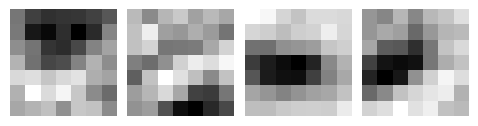

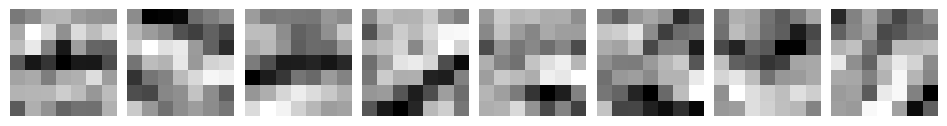

In [386]:
plot_kernels(params['layers.0.weight'], num_cols=10)
plot_kernels(params['layers.3.weight'], num_cols=10)

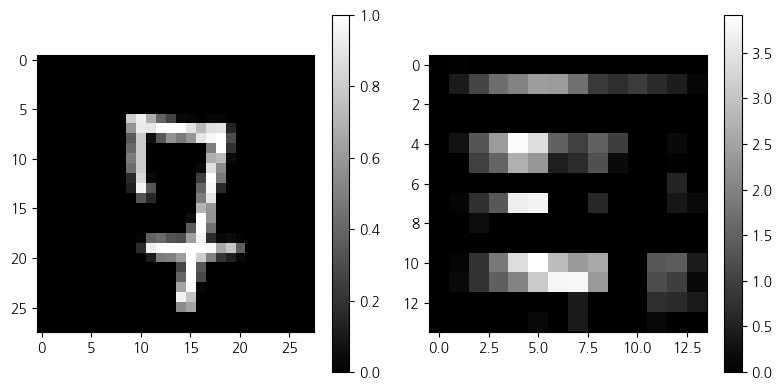

In [124]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)  # 활성화 함수를 적용할 수 있습니다.

# conv2d는 0번째, 3번째임
# hook = model.layers[0].register_forward_hook(get_activation)
hook = model.layers[3].register_forward_hook(get_activation)

# 모델 실행
data = [x for x,y in train_loader][0]
data = data[7].unsqueeze(0)
output = model(data)

fig = plt.figure(figsize=(8,4))

fig.add_subplot(121)
plt.imshow(data.squeeze(0,1), cmap='gray')
plt.colorbar()

# 활성화의 첫 번째 채널 시각화
fig.add_subplot(122)
act = activation.squeeze().detach().numpy()
plt.imshow(act[0], cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

hook.remove()  # 필요없어진 후킹을 제거합니다.

In [125]:
import torch.nn.functional as F

class GradCam:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gradient = None
        self.activation = None
        self.model.eval()  # 모델을 평가 모드로 설정

        # 레이어의 출력을 훅으로 캡처
        def forward_hook(module, input, output):
            self.activation = output
            return None

        # 레이어의 그라디언트를 훅으로 캡처
        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]
            return None

        # 레이어에 훅 등록
        layer = dict([*self.model.named_modules()])[layer_name]
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

    def __call__(self, x, index=None, resize=None):
        # 모델의 전방향 패스 실행
        output = self.model(x)
        if index is None:
            index = output.argmax(dim=1).item()

        # 타겟 클래스에 대한 출력의 그라디언트 계산
        one_hot = torch.zeros_like(output)
        one_hot[0][index] = 1
        output.backward(gradient=one_hot)

        # 그라디언트와 활성화를 사용하여 Grad-CAM 계산
        weights = self.gradient.mean(dim=[0, 2, 3], keepdim=True)
        cam = torch.sum(weights * self.activation, dim=1)[0]
        cam = torch.relu(cam)  # ReLU를 적용하여 음수를 0으로 설정
        cam = cam - cam.min()
        cam = cam / cam.max()

        if resize is not None:
            cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=resize, mode='bilinear', align_corners=False)

            # 첫 번째 원소 선택
            cam = cam[0][0]

        return cam.detach().cpu().numpy()

In [295]:
# pip install grad-cam
# 참조 : https://honbul.tistory.com/54
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

In [376]:
named_modules = dict([*model.named_modules()])
named_modules.pop('')
named_modules.pop('layers')
named_modules

{'layers.0': Conv2d(1, 4, kernel_size=(7, 7), stride=(1, 1), padding=same),
 'layers.1': ReLU(),
 'layers.2': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 'layers.3': Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=same),
 'layers.4': ReLU(),
 'layers.5': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 'layers.6': Flatten(start_dim=1, end_dim=-1),
 'layers.7': Linear(in_features=392, out_features=64, bias=True),
 'layers.8': ReLU(),
 'layers.9': Linear(in_features=64, out_features=10, bias=True),
 'layers.10': Dropout(p=0.25, inplace=False)}

100%|██████████| 8/8 [00:00<00:00, 395.66it/s]


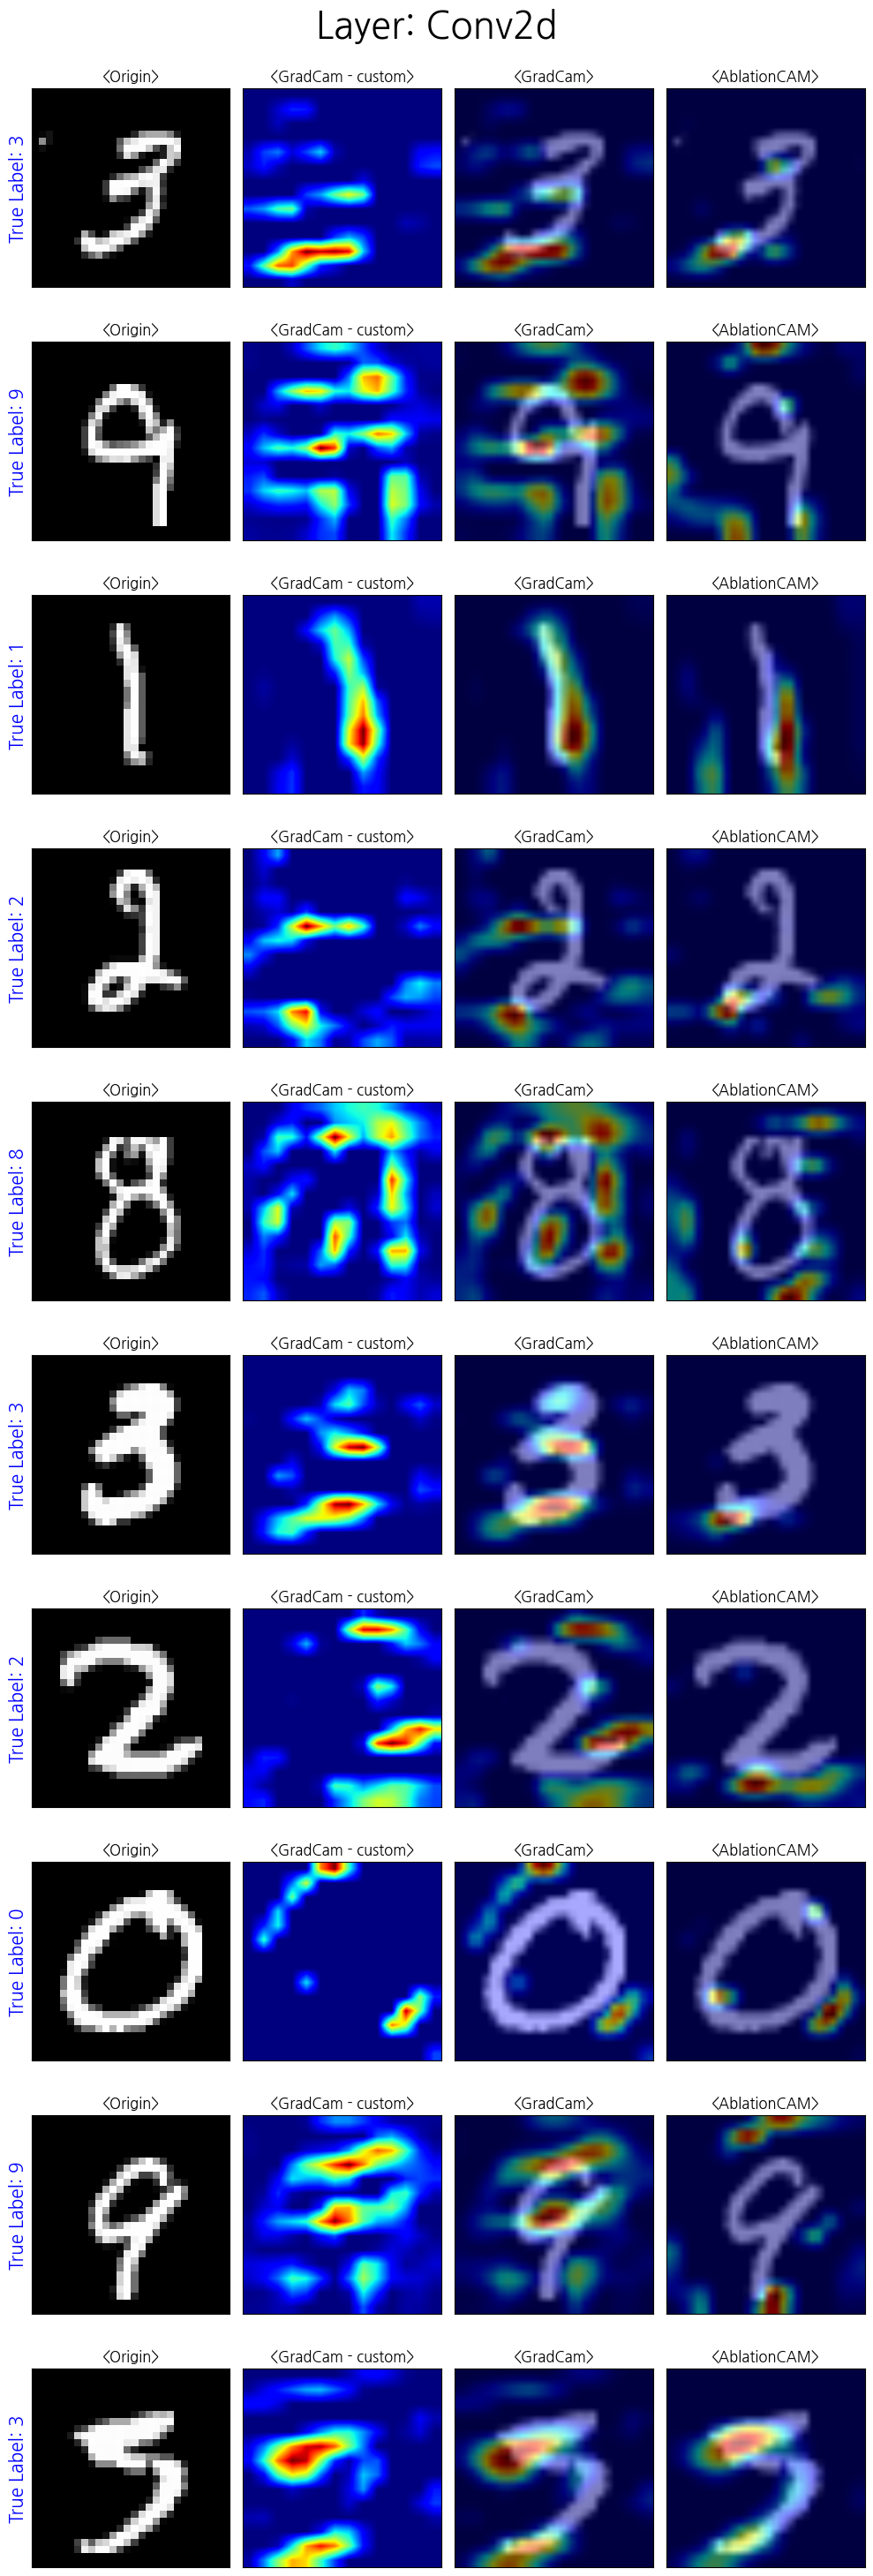

In [388]:
n = 10
layer_name = 'layers.3'

layer = named_modules[layer_name]
class_name = layer.__class__.__name__

fig = plt.figure(figsize=(10,3*n))
for i in range(n):
    # data select
    choice1 = random.choice(range(len(train_loader)))
    data, label = [(x,y) for x,y in train_loader][choice1]

    choice2 = random.choice(range(len(data)))
    d = data[choice2].unsqueeze(0)
    t = label[choice2].item()
    #print(f'{choice1=}, {choice2=}, label={t}')

    # (1) origin
    origin = d.squeeze(0,1)

    # (2) GradCam - custom
    gc = GradCam(model, layer_name)
    cam1 = gc(d, index=t, resize=(224,224))

    # (3) pytorch_grad_cam
    img = origin.unsqueeze(-1)
    img = np.float32(img)
    targets = [ClassifierOutputTarget(t)]

    # (3-1) GradCam
    cam = GradCAM(model=model, target_layers=[layer])
    cam.batch_size = 1
    grayscale_cam = cam(input_tensor=d, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    image = Image.fromarray(visualization)
    cam2 = image.resize((224, 224), Image.BILINEAR)  # 300x300 크기로 변경

    # (3-2) AblationCAM
    cam = AblationCAM(model=model, target_layers=[layer])
    cam.batch_size = 1
    grayscale_cam = cam(input_tensor=d, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    image = Image.fromarray(visualization)
    cam3 = image.resize((224, 224), Image.BILINEAR)  # 300x300 크기로 변경

    # plotting
    fig.add_subplot(n, 4, 4*i+1)
    plt.imshow(origin, cmap='gray')
    plt.title('<Origin>')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f'True Label: {t}', fontsize=15, color='blue')

    fig.add_subplot(n, 4, 4*i+2)
    plt.imshow(cam1, cmap='jet')
    plt.title('<GradCam - custom>')
    plt.xticks([])
    plt.yticks([])

    fig.add_subplot(n, 4, 4*i+3)
    plt.imshow(cam2)
    plt.title('<GradCam>')
    plt.xticks([])
    plt.yticks([])

    fig.add_subplot(n, 4, 4*i+4)
    plt.imshow(cam3)
    plt.title('<AblationCAM>')
    plt.xticks([])
    plt.yticks([])

plt.suptitle(f'Layer: {class_name}\n', fontsize=30)
plt.tight_layout()
plt.show()

In [ ]:
# efficient net
# 참조 : https://ffighting.net/deep-learning-paper-review/vision-model/efficientnet/